# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/CERNET-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'GRU'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'GRU_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'GRU_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time        OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2013-02-19-22-10  3.897921e+06  3660.257162  2.038509e+06  54492.199769   
1  2013-02-19-22-15  3.714310e+06  4102.475155  2.010658e+06  44398.935617   
2  2013-02-19-22-20  3.824844e+06  3475.827556  2.022040e+06  39446.603085   
3  2013-02-19-22-25  3.967014e+06  3616.911661  2.005270e+06  42316.578675   
4  2013-02-19-22-30  3.708735e+06  3464.036062  2.017856e+06  44239.873981   

          OD_1-5         OD_1-6         OD_1-7         OD_1-8        OD_1-9  \
0  234230.295946   84819.101740  326551.951138   70567.750666  12520.192382   
1  200445.246659  118932.827733  345145.938997   73246.388000  13969.378085   
2  191539.466968  143379.788071  380456.462916   88085.648186  13683.572258   
3  171440.464195  139779.197759  399477.041689  100997.455279  13928.180880   
4  150425.682249  134512.997369  388659.765735   95906.154986  12303.793875   

   ...  OD_14-5  OD_14-6   OD_14-7      OD_14-8  OD_14-9      OD_14-10  \
0  ...      0.0      0.0  0.000000  1381.832533      0.0  10897.764534   
1  ...      0.0      0.0  0.000000  1123.647467      0.0  10333.189333   
2  ...      0.0      0.0  0.000000  1430.037600      0.0   9900.663200   
3  ...      0.0      0.0  0.000000  1954.184000      0.0  10663.956267   
4  ...      0.0      0.0  0.083324  3102.597333      0.0   7687.432800   

   OD_14-11      OD_14-12  OD_14-13  OD_14-14  
0       0.0  36048.613333       0.0       0.0  
1       0.0  32883.840000       0.0       0.0  
2       0.0  28923.253333       0.0       0.0  
3       0.0  34839.440000       0.0       0.0  
4       0.0  35943.493333       0.0       0.0  

[5 rows x 197 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
# data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
# df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2013-03-19 16:50:00', freq='5T')

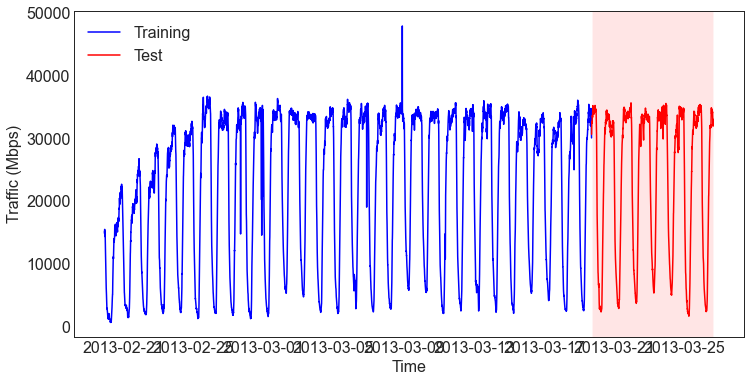

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

2.0845760812827483


In [26]:
print(np.min(data.flatten()))

-0.004873735825012876


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

9999


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(9989, 10, 196)

In [32]:
y_data.shape

(9989, 1, 196)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(9989, 196)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

7990

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6392

In [40]:
valid_length

1598

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6392, 196, 10)

In [43]:
y_train.shape

(6392, 196)

In [44]:
X_valid.shape

(1598, 196, 10)

In [45]:
y_valid.shape

(1598, 196)

In [46]:
X_test.shape

(1999, 196, 10)

In [47]:
y_test.shape

(1999, 196)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(7990, 196, 10)

In [50]:
y.shape

(7990, 196)

In [51]:
splits

((#6392) [0,1,2,3,4,5,6,7,8,9...],
 (#1598) [6392,6393,6394,6395,6396,6397,6398,6399,6400,6401...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#7990) [(TSTensor(vars:196, len:10), tensor([3.0473e-01, 4.0979e-03, 8.5294e-01, 3.2505e-01, 4.2390e-01, 1.7035e-01,
        2.3749e-01, 9.5876e-02, 6.0455e-02, 2.5291e-01, 2.3859e-01, 3.9024e-01,
        3.8565e-01, 5.5069e-01, 3.1508e-03, 0.0000e+00, 3.8347e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1409e-03, 0.0000e+00, 3.2674e-05,
        0.0000e+00, 1.0261e-03, 0.0000e+00, 0.0000e+00, 5.8814e-01, 3.1805e-05,
        3.6734e-02, 2.0680e-02, 1.1481e-01, 1.7415e-01, 1.7546e-01, 4.7027e-02,
        3.2714e-01, 3.2840e-01, 2.6392e-01, 2.5046e-01, 2.2083e-01, 8.3459e-01,
        8.6948e-02, 0.0000e+00, 3.6272e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3882e-04, 0.0000e+00, 6.2002e-02, 0.0000e+00, 4.5756e-02,
        0.0000e+00, 0.0000e+00, 4.2969e-01, 0.0000e+00, 1.5752e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6673e-02, 0.0000e+00, 1.0326e-01,
        0.0000e+00, 1.9820e-01, 0.0000e+00, 0.0000e+00, 1.3957e-01, 1.2948e-05,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2da0a333f48>,
 'lr': <hyperopt.pyll.base.Apply at 0x2da0a3460c8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2da0a3466c8>,
 'patience': <hyperopt.pyll.base.Apply at 0x2da0a346588>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2da0a34c448>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x2da0a34c208>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x2da0a34ca08>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x2da0a35df48>}

In [55]:
# clear memory 
gc.collect()

0

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = GRU
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  0%|                                                                          | 0/100 [00:03<?, ?trial/s, best loss=?]

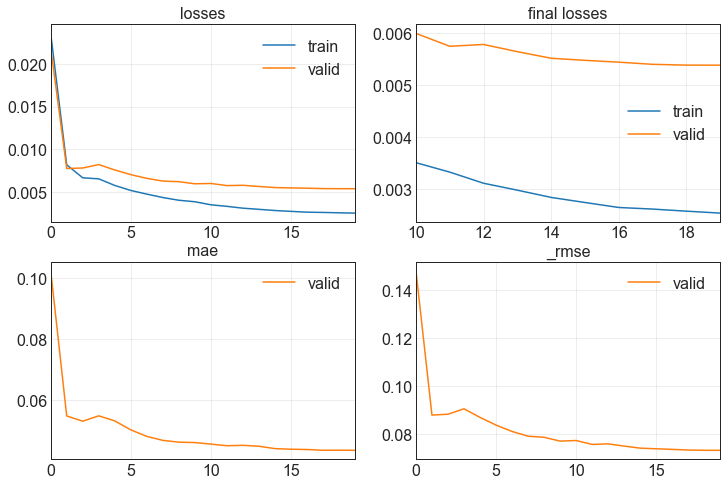

36.46728992462158                                                                                                      
[0.002530528698116541, 0.00538532854989171, 0.04342837259173393, 0.07338479906320572]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
  1%|▍                                            | 1/100 [00:40<1:05:17, 39.57s/trial, best loss: 0.00538532854989171]

No improvement since epoch 0: early stopping                                                                           
  1%|▍                                            | 1/100 [00:48<1:05:17, 39.57s/trial, best loss: 0.00538532854989171]

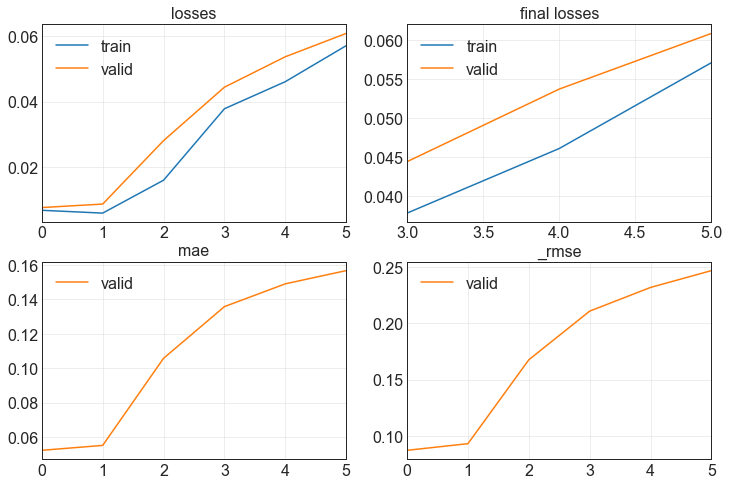

7.792241811752319                                                                                                      
[0.05713292583823204, 0.060885727405548096, 0.15670602023601532, 0.2467503547668457]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
  2%|▉                                              | 2/100 [00:49<49:37, 30.38s/trial, best loss: 0.00538532854989171]

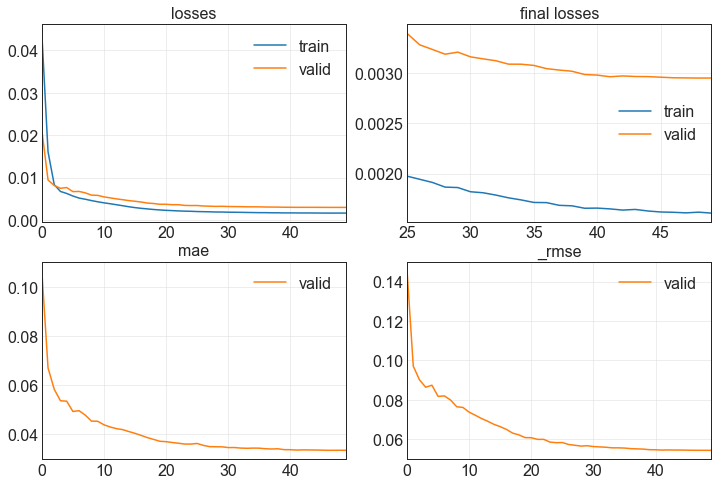

30.241642475128174                                                                                                     
[0.0016056728782132268, 0.0029528255108743906, 0.03324390947818756, 0.054339900612831116]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  3%|█▎                                           | 3/100 [01:21<49:35, 30.68s/trial, best loss: 0.0029528255108743906]

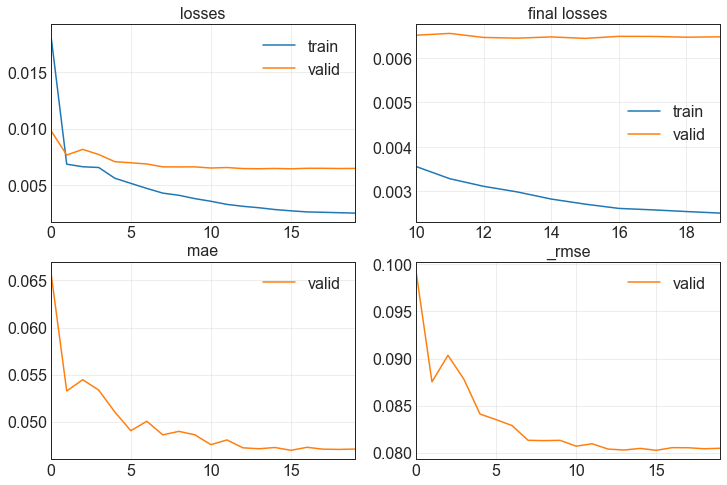

61.976935625076294                                                                                                     
[0.0025112612638622522, 0.0064746481366455555, 0.04709213599562645, 0.08046519756317139]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  4%|█▋                                         | 4/100 [02:24<1:04:40, 40.43s/trial, best loss: 0.0029528255108743906]

No improvement since epoch 0: early stopping                                                                           
  4%|█▋                                         | 4/100 [02:40<1:04:40, 40.43s/trial, best loss: 0.0029528255108743906]

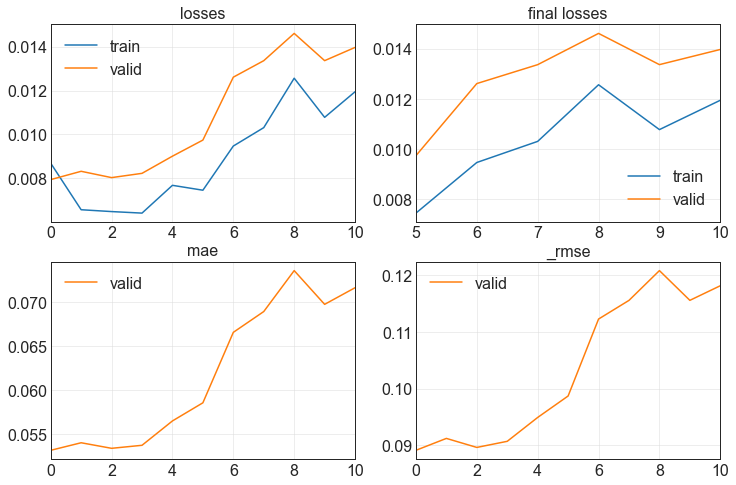

17.12980008125305                                                                                                      
[0.011946114711463451, 0.013966712169349194, 0.07165475189685822, 0.11818083375692368]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  5%|██▎                                          | 5/100 [02:42<53:28, 33.78s/trial, best loss: 0.0029528255108743906]

No improvement since epoch 0: early stopping                                                                           
  5%|██▎                                          | 5/100 [02:49<53:28, 33.78s/trial, best loss: 0.0029528255108743906]

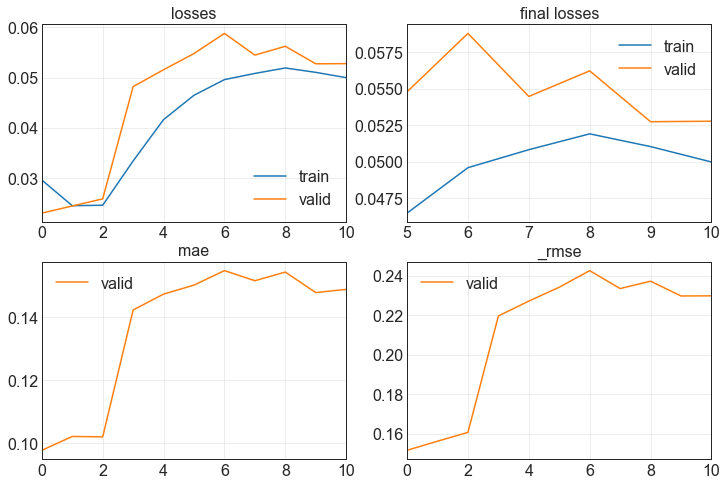

7.6449995040893555                                                                                                     
[0.04996851086616516, 0.05276690423488617, 0.14866019785404205, 0.22971047461032867]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  6%|██▋                                          | 6/100 [02:51<41:10, 26.28s/trial, best loss: 0.0029528255108743906]

No improvement since epoch 70: early stopping                                                                          
  6%|██▋                                          | 6/100 [07:19<41:10, 26.28s/trial, best loss: 0.0029528255108743906]

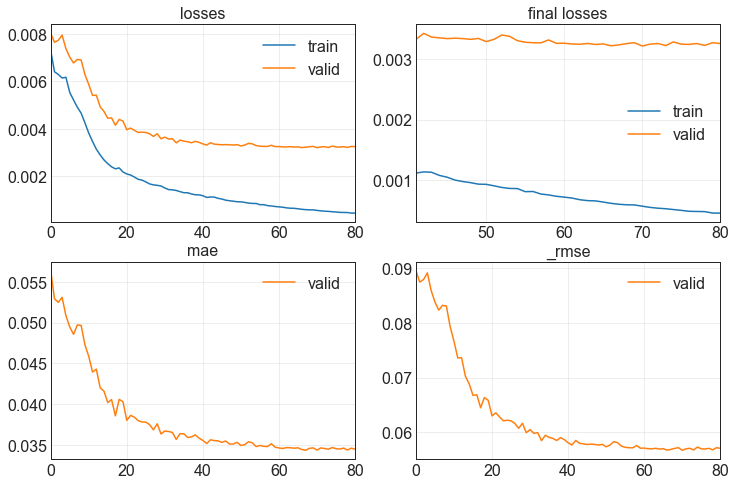

268.44793343544006                                                                                                     
[0.00045746585237793624, 0.003254145151004195, 0.03447582200169563, 0.057045113295316696]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
  7%|███                                        | 7/100 [07:20<2:33:51, 99.26s/trial, best loss: 0.0029528255108743906]

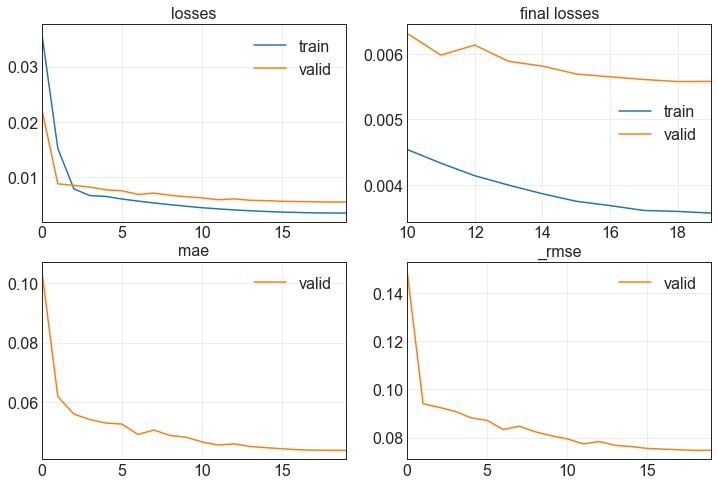

16.35442566871643                                                                                                      
[0.0035686467308551073, 0.005579119548201561, 0.04399300366640091, 0.07469350099563599]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  8%|███▍                                       | 8/100 [07:38<1:54:35, 74.73s/trial, best loss: 0.0029528255108743906]

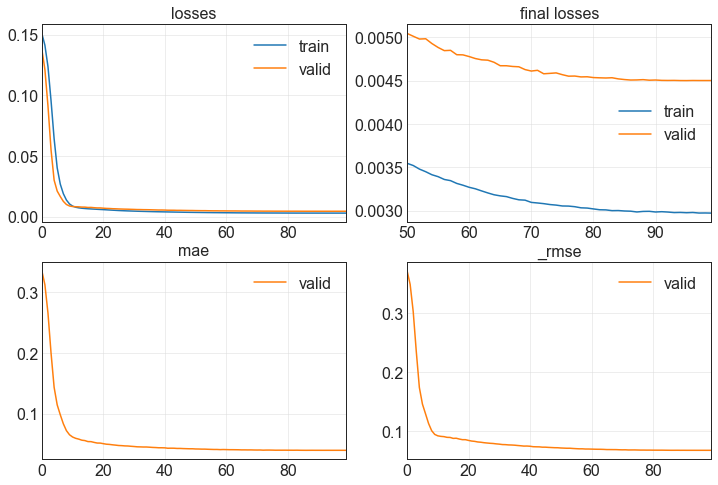

42.02766036987305                                                                                                      
[0.002970742527395487, 0.004500255919992924, 0.039672695100307465, 0.0670839473605156]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
  9%|███▊                                       | 9/100 [08:21<1:38:58, 65.26s/trial, best loss: 0.0029528255108743906]

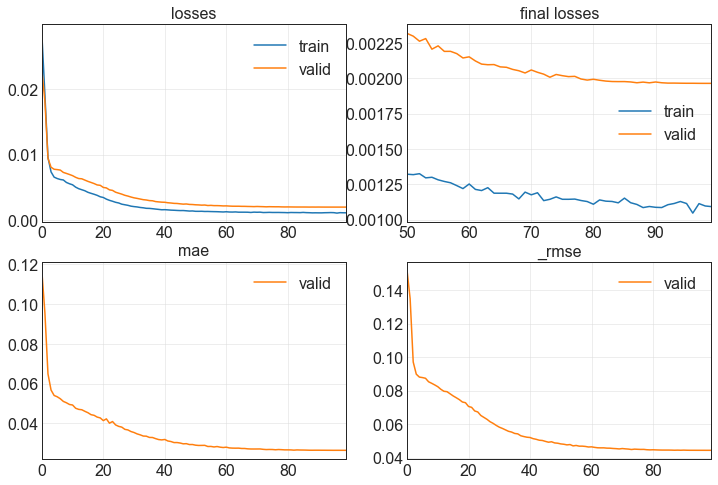

230.51744151115417                                                                                                     
[0.0010922448709607124, 0.0019641739781945944, 0.026491722092032433, 0.044318996369838715]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 10%|████                                     | 10/100 [12:13<2:52:45, 115.18s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 8: early stopping                                                                           
 10%|████                                     | 10/100 [12:55<2:52:45, 115.18s/trial, best loss: 0.0019641739781945944]

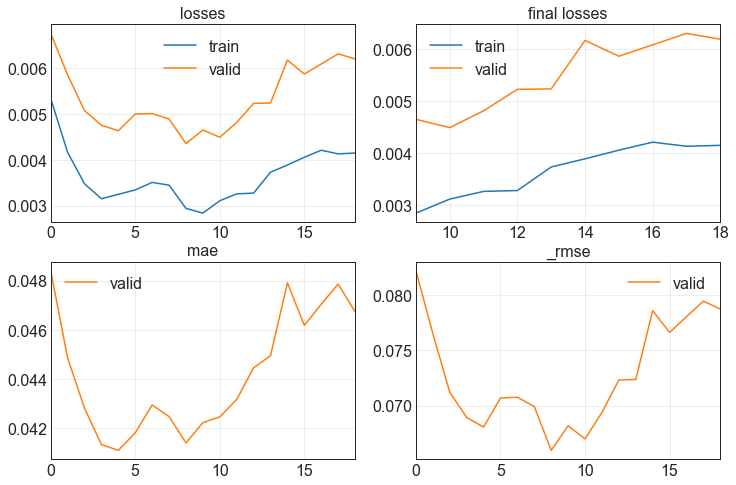

42.82223033905029                                                                                                      
[0.004147154279053211, 0.00619674613699317, 0.04673214256763458, 0.07871941477060318]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 11%|████▌                                     | 11/100 [12:57<2:19:10, 93.83s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 2: early stopping                                                                           
 11%|████▌                                     | 11/100 [13:34<2:19:10, 93.83s/trial, best loss: 0.0019641739781945944]

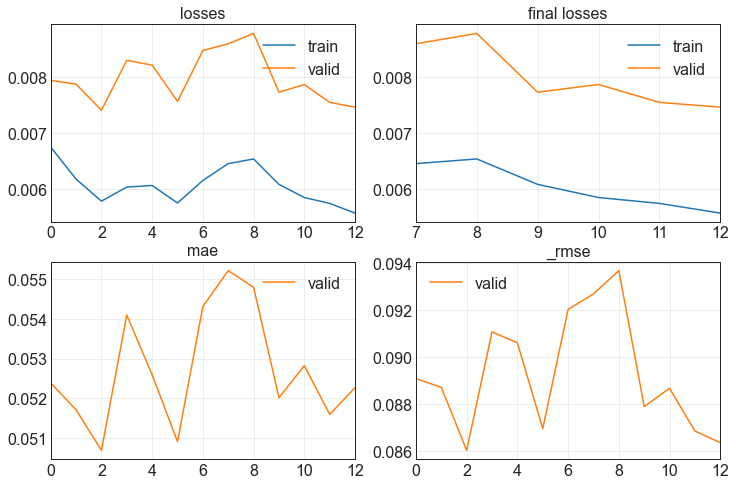

37.42015314102173                                                                                                      
[0.005569561384618282, 0.007459564600139856, 0.052268121391534805, 0.08636876940727234]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 12%|█████                                     | 12/100 [13:35<1:53:17, 77.25s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 32: early stopping                                                                          
 12%|█████                                     | 12/100 [16:41<1:53:17, 77.25s/trial, best loss: 0.0019641739781945944]

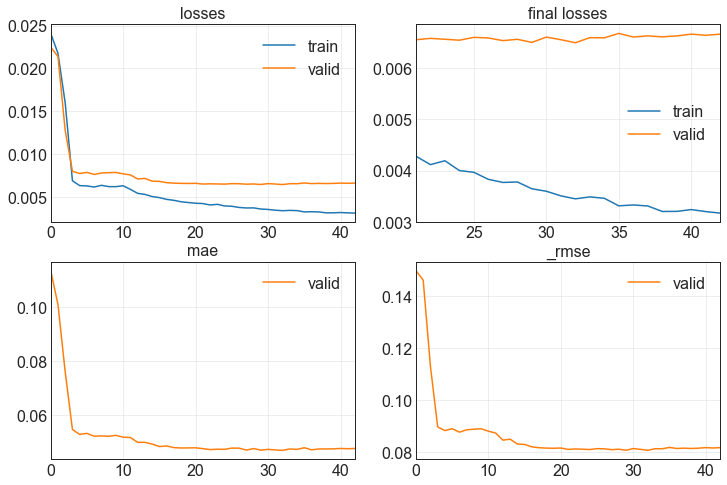

186.6648817062378                                                                                                      
[0.003169116098433733, 0.0066609312780201435, 0.0476507842540741, 0.08161453157663345]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 13%|█████▎                                   | 13/100 [16:43<2:40:06, 110.42s/trial, best loss: 0.0019641739781945944]

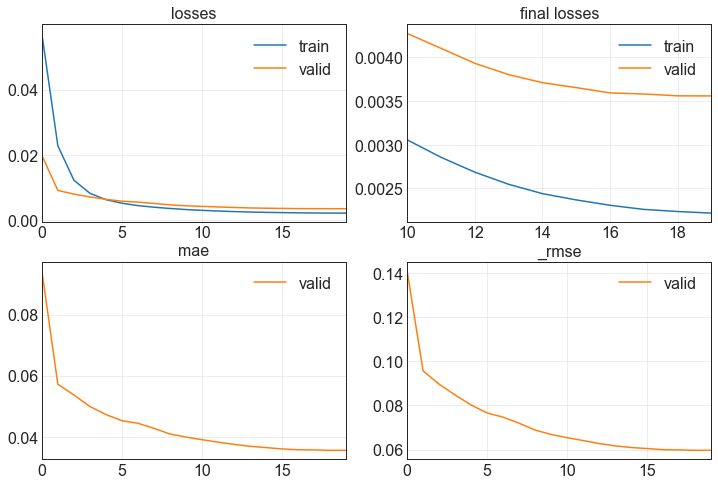

8.993145227432251                                                                                                      
[0.0022178208455443382, 0.003559310920536518, 0.03556065633893013, 0.059659965336322784]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 14%|█████▉                                    | 14/100 [16:53<1:55:08, 80.33s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 52: early stopping                                                                          
 14%|█████▉                                    | 14/100 [19:01<1:55:08, 80.33s/trial, best loss: 0.0019641739781945944]

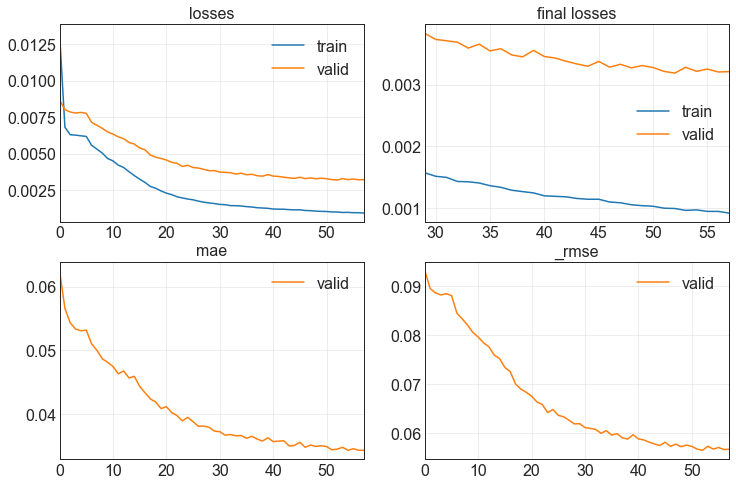

128.51541900634766                                                                                                     
[0.0009138565510511398, 0.003209503833204508, 0.03429875895380974, 0.0566524863243103]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 15%|██████▎                                   | 15/100 [19:03<2:14:45, 95.13s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 3: early stopping                                                                           
 15%|██████▎                                   | 15/100 [19:18<2:14:45, 95.13s/trial, best loss: 0.0019641739781945944]

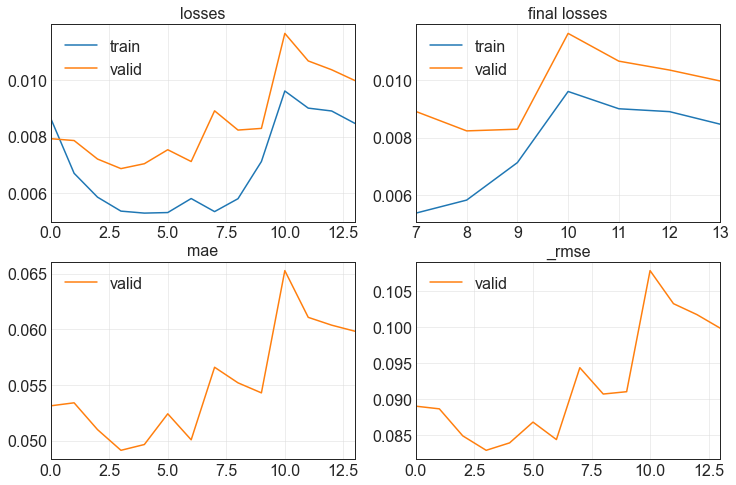

15.763217687606812                                                                                                     
[0.008463921025395393, 0.00997268594801426, 0.059821490198373795, 0.09986333549022675]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 16%|██████▋                                   | 16/100 [19:20<1:40:19, 71.66s/trial, best loss: 0.0019641739781945944]

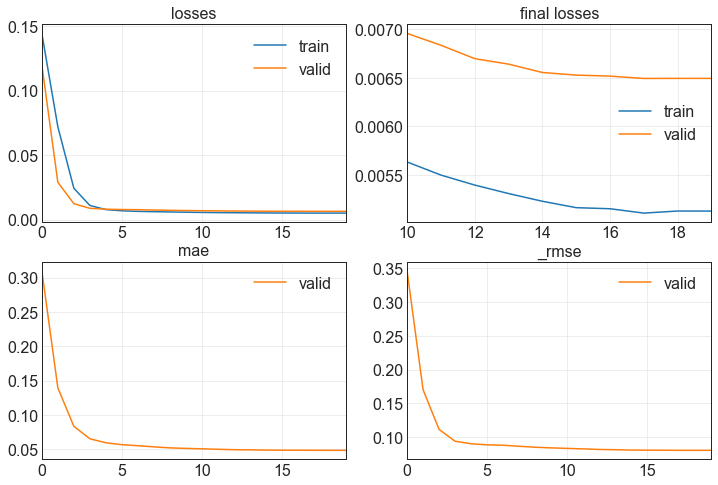

14.055259943008423                                                                                                     
[0.005124720744788647, 0.006494161672890186, 0.04835991933941841, 0.08058636635541916]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 17%|███████▏                                  | 17/100 [19:35<1:15:41, 54.71s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 36: early stopping                                                                          
 17%|███████▏                                  | 17/100 [20:33<1:15:41, 54.71s/trial, best loss: 0.0019641739781945944]

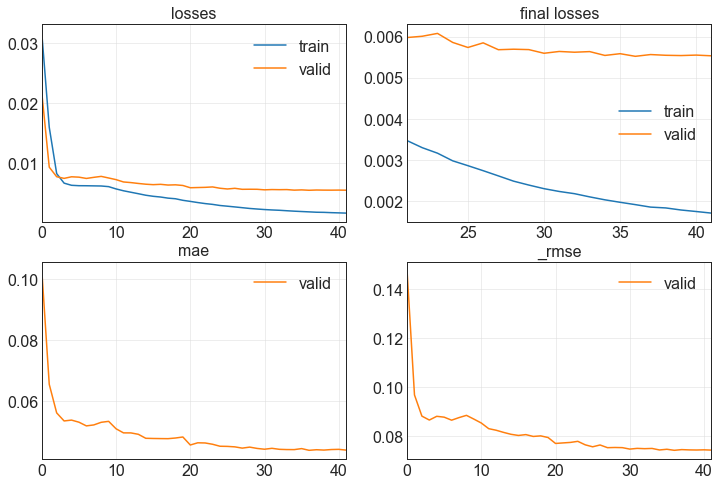

58.488866567611694                                                                                                     
[0.0017117945244535804, 0.005531424656510353, 0.0440562441945076, 0.07437354326248169]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 18%|███████▌                                  | 18/100 [20:34<1:16:46, 56.18s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 2: early stopping                                                                           
 18%|███████▌                                  | 18/100 [20:58<1:16:46, 56.18s/trial, best loss: 0.0019641739781945944]

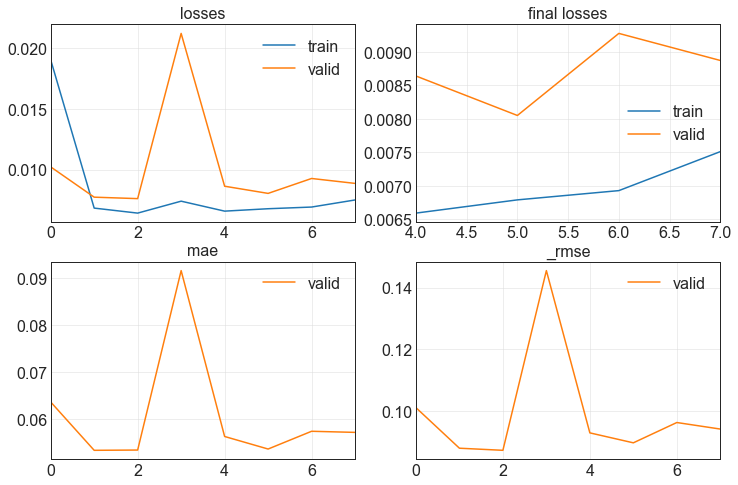

24.26010251045227                                                                                                      
[0.007511546835303307, 0.008871045894920826, 0.05716793239116669, 0.09418623149394989]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 19%|███████▉                                  | 19/100 [21:00<1:03:22, 46.95s/trial, best loss: 0.0019641739781945944]

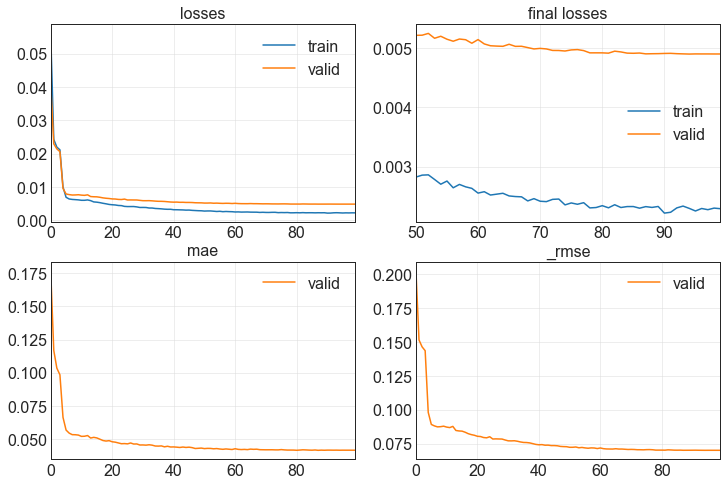

568.9336779117584                                                                                                      
[0.002287847688421607, 0.0049042487516999245, 0.04161054641008377, 0.0700303390622139]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 20%|████████▏                                | 20/100 [30:30<4:31:53, 203.91s/trial, best loss: 0.0019641739781945944]

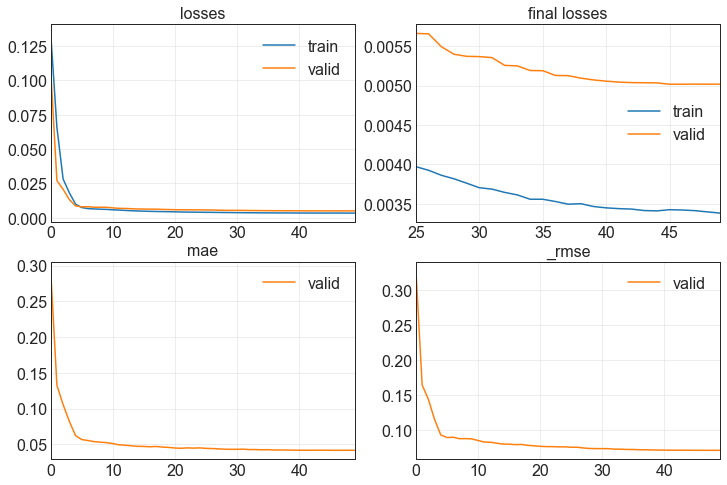

30.773372888565063                                                                                                     
[0.003380996873602271, 0.005016799550503492, 0.04185372218489647, 0.0708293691277504]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 21%|████████▌                                | 21/100 [31:02<3:20:33, 152.32s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 71: early stopping                                                                          
 21%|████████▌                                | 21/100 [31:46<3:20:33, 152.32s/trial, best loss: 0.0019641739781945944]

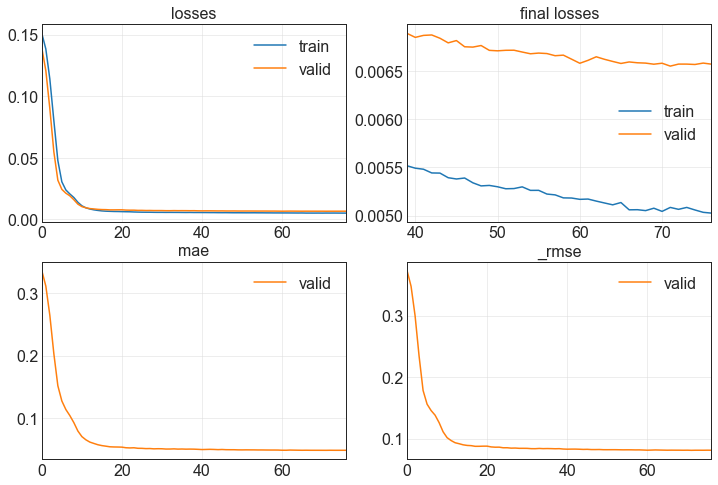

44.34408617019653                                                                                                      
[0.005025405902415514, 0.00657153595238924, 0.048176251351833344, 0.08106501400470734]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 22%|█████████                                | 22/100 [31:47<2:36:20, 120.26s/trial, best loss: 0.0019641739781945944]

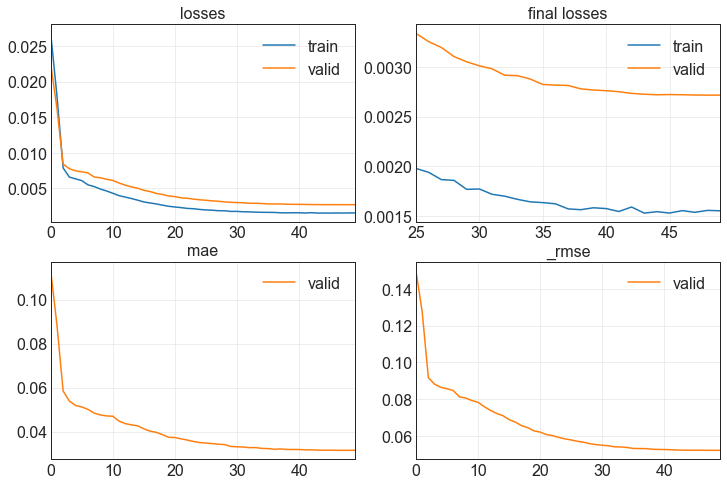

109.12444949150085                                                                                                     
[0.0015538507141172886, 0.002715224865823984, 0.03153303265571594, 0.05210781842470169]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 23%|█████████▍                               | 23/100 [33:38<2:30:28, 117.26s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 92: early stopping                                                                          
 23%|█████████▍                               | 23/100 [37:20<2:30:28, 117.26s/trial, best loss: 0.0019641739781945944]

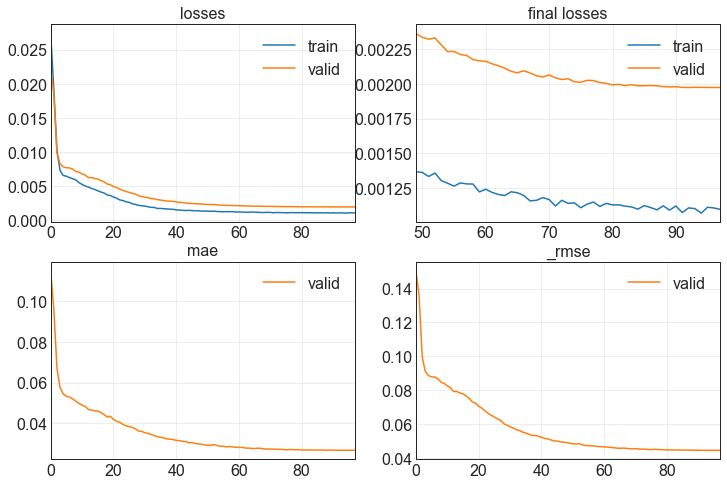

222.71945524215698                                                                                                     
[0.001096641062758863, 0.001973229693248868, 0.026774773374199867, 0.04442104697227478]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 24%|█████████▊                               | 24/100 [37:22<3:09:01, 149.24s/trial, best loss: 0.0019641739781945944]

No improvement since epoch 94: early stopping                                                                          
 24%|█████████▊                               | 24/100 [41:59<3:09:01, 149.24s/trial, best loss: 0.0019641739781945944]

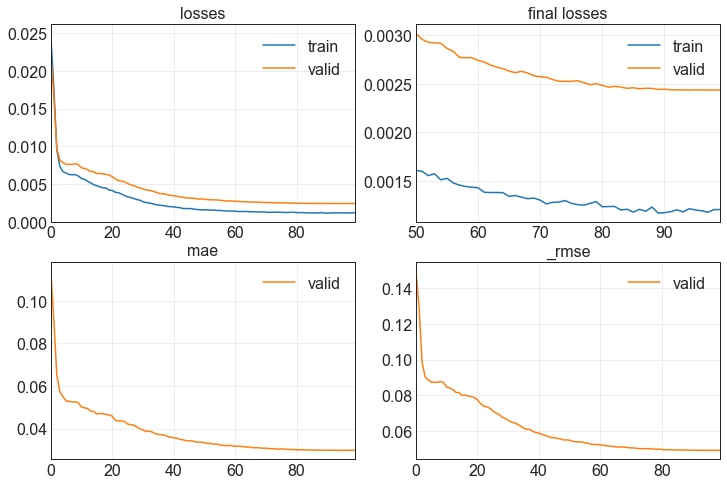

278.3068652153015                                                                                                      
[0.001205245265737176, 0.002437356160953641, 0.029814235866069794, 0.04936959594488144]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 25%|██████████▎                              | 25/100 [42:01<3:55:23, 188.32s/trial, best loss: 0.0019641739781945944]

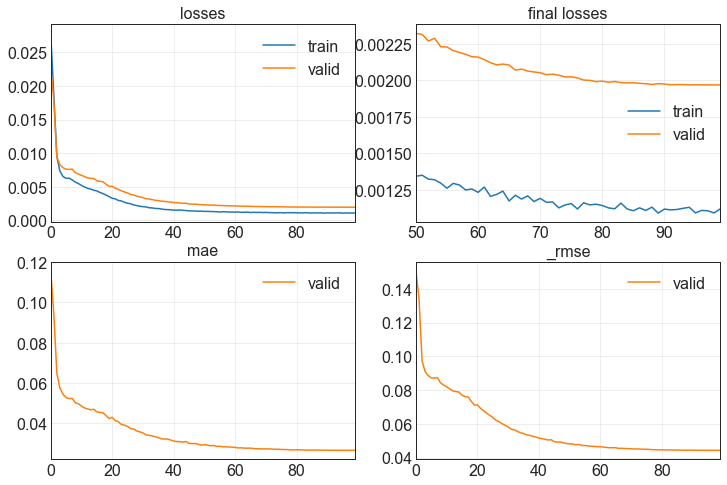

229.32080483436584                                                                                                     
[0.0011191264493390918, 0.001969503005966544, 0.026687337085604668, 0.044379089027643204]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 26%|██████████▋                              | 26/100 [45:52<4:07:53, 200.99s/trial, best loss: 0.0019641739781945944]

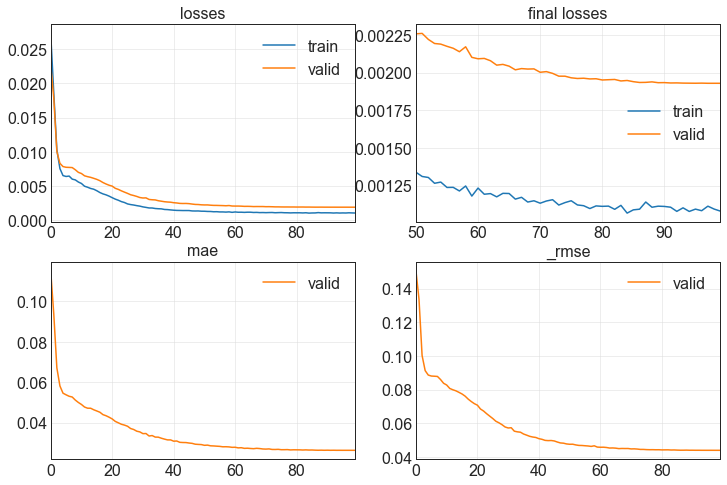

233.18807411193848                                                                                                     
[0.0010809091618284583, 0.0019296978134661913, 0.026257721707224846, 0.04392831772565842]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 27%|███████████                              | 27/100 [49:46<4:16:44, 211.02s/trial, best loss: 0.0019296978134661913]

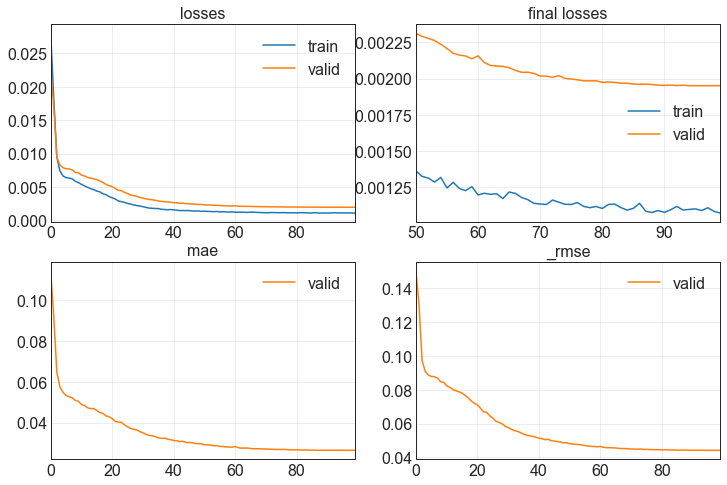

229.17814469337463                                                                                                     
[0.0010703598381951451, 0.0019507621182128787, 0.026447487995028496, 0.04416743293404579]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 28%|███████████▍                             | 28/100 [53:36<4:20:13, 216.85s/trial, best loss: 0.0019296978134661913]

No improvement since epoch 35: early stopping                                                                          
 28%|███████████▍                             | 28/100 [56:30<4:20:13, 216.85s/trial, best loss: 0.0019296978134661913]

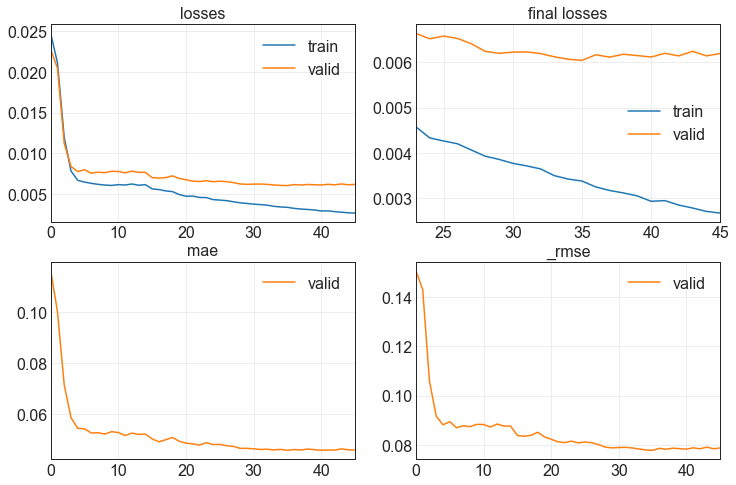

174.4151475429535                                                                                                      
[0.0026661823503673077, 0.006195169407874346, 0.04577984660863876, 0.07870940864086151]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 29%|███████████▉                             | 29/100 [56:32<4:01:57, 204.47s/trial, best loss: 0.0019296978134661913]

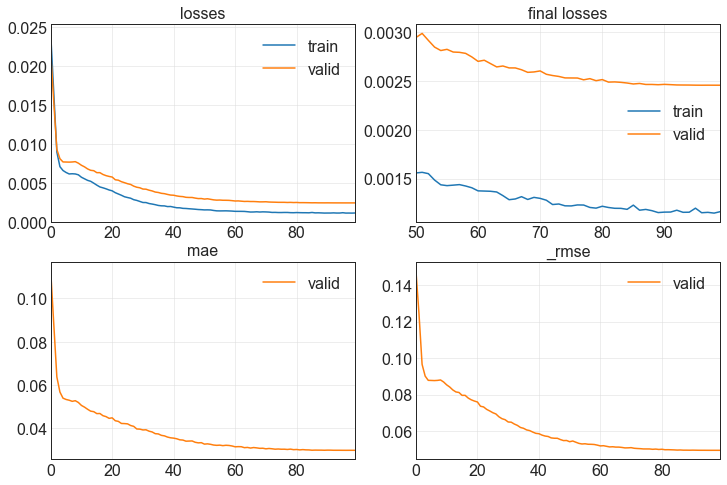

285.82583141326904                                                                                                     
[0.001161210355348885, 0.002456115325912833, 0.029826568439602852, 0.04955920949578285]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 30%|███████████▋                           | 30/100 [1:01:19<4:27:26, 229.23s/trial, best loss: 0.0019296978134661913]

No improvement since epoch 18: early stopping                                                                          
 30%|███████████▋                           | 30/100 [1:01:37<4:27:26, 229.23s/trial, best loss: 0.0019296978134661913]

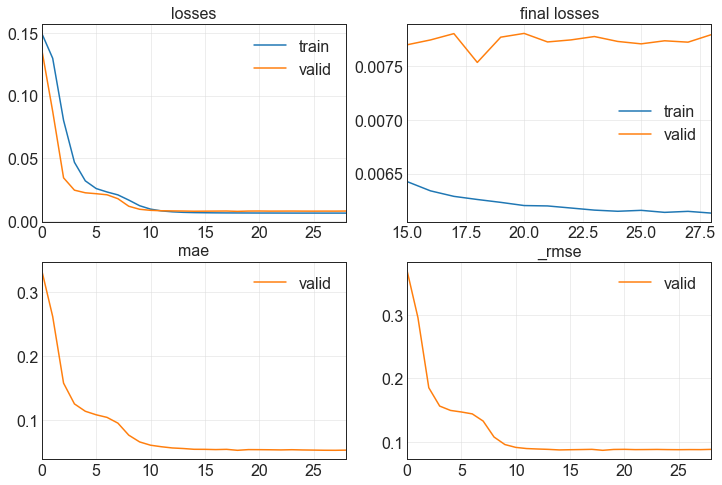

18.01106572151184                                                                                                      
[0.006134729832410812, 0.007789143826812506, 0.05231597274541855, 0.08825613558292389]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 31%|████████████                           | 31/100 [1:01:38<3:11:09, 166.23s/trial, best loss: 0.0019296978134661913]

No improvement since epoch 61: early stopping                                                                          
 31%|████████████                           | 31/100 [1:04:19<3:11:09, 166.23s/trial, best loss: 0.0019296978134661913]

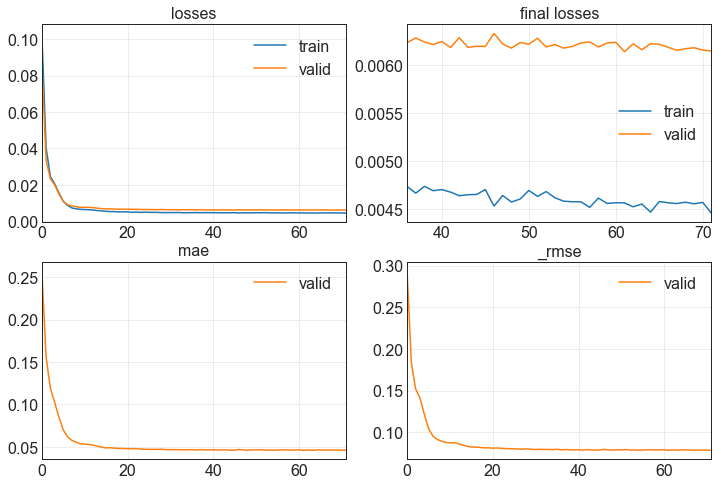

160.78494358062744                                                                                                     
[0.004457965027540922, 0.006143501959741116, 0.04613196849822998, 0.07838049530982971]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 32%|████████████▍                          | 32/100 [1:04:20<3:06:56, 164.94s/trial, best loss: 0.0019296978134661913]

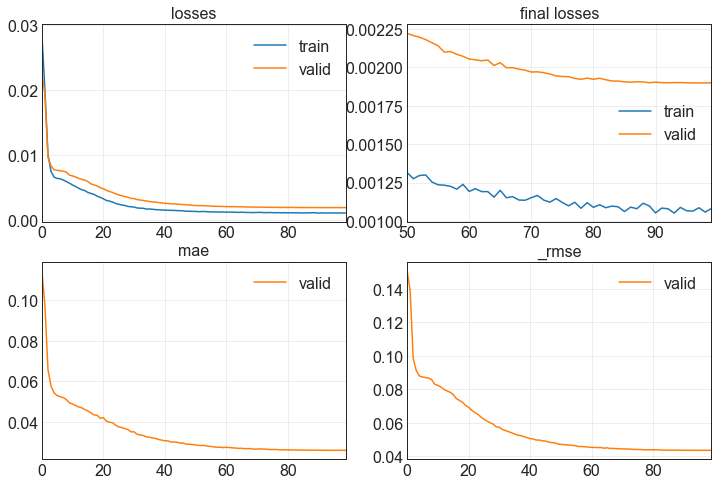

228.90701627731323                                                                                                     
[0.0010823504999279976, 0.001899293391034007, 0.02603071555495262, 0.043580882251262665]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 33%|█████████████▏                          | 33/100 [1:08:10<3:26:00, 184.48s/trial, best loss: 0.001899293391034007]

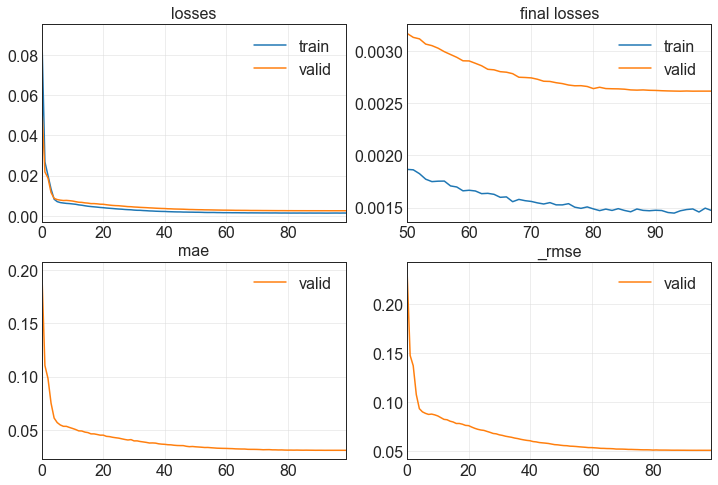

120.63284945487976                                                                                                     
[0.0014721170300617814, 0.0026163936126977205, 0.030946722254157066, 0.05115069821476936]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 34%|█████████████▌                          | 34/100 [1:10:12<3:02:14, 165.68s/trial, best loss: 0.001899293391034007]

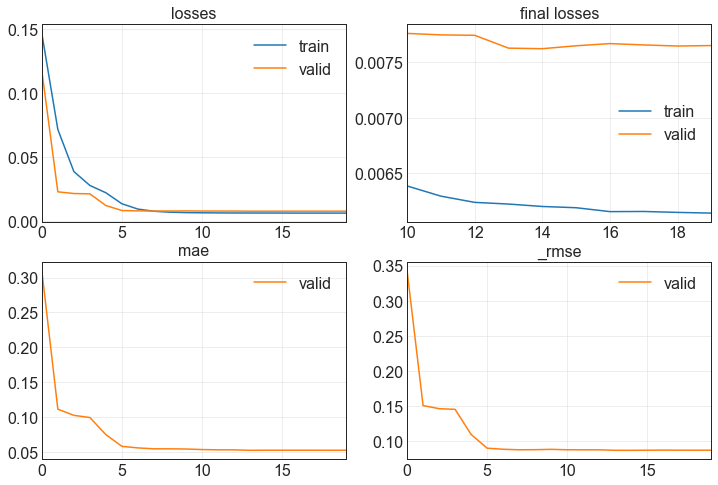

14.143854856491089                                                                                                     
[0.006143395788967609, 0.007650007028132677, 0.05285001918673515, 0.08746431767940521]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 35%|██████████████                          | 35/100 [1:10:27<2:10:35, 120.55s/trial, best loss: 0.001899293391034007]

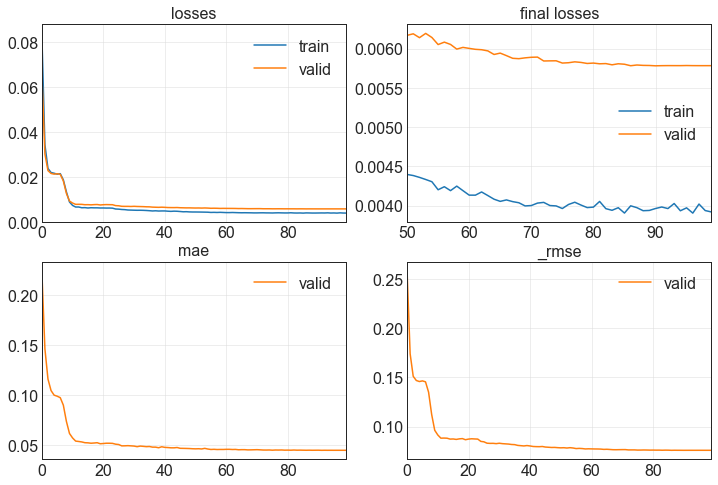

318.42963123321533                                                                                                     
[0.003919408656656742, 0.005783958360552788, 0.04490693658590317, 0.07605233788490295]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 36%|██████████████▍                         | 36/100 [1:15:47<3:12:15, 180.25s/trial, best loss: 0.001899293391034007]

No improvement since epoch 0: early stopping                                                                           
 36%|██████████████▍                         | 36/100 [1:15:59<3:12:15, 180.25s/trial, best loss: 0.001899293391034007]

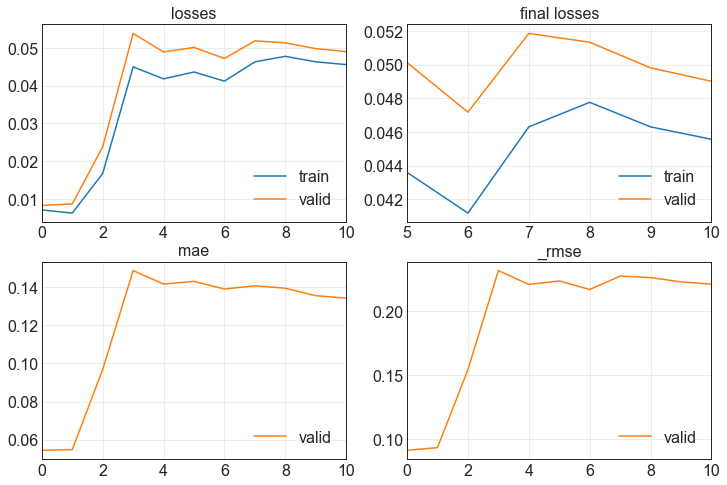

12.94425916671753                                                                                                      
[0.04557061940431595, 0.0490155890583992, 0.13409686088562012, 0.2213946431875229]                                     
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 37%|██████████████▊                         | 37/100 [1:16:01<2:16:54, 130.39s/trial, best loss: 0.001899293391034007]

No improvement since epoch 15: early stopping                                                                          
 37%|██████████████▊                         | 37/100 [1:17:48<2:16:54, 130.39s/trial, best loss: 0.001899293391034007]

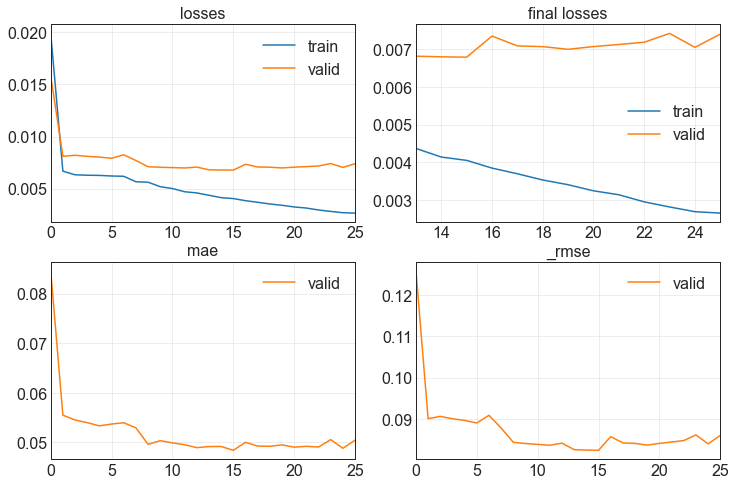

107.64726519584656                                                                                                     
[0.002660345286130905, 0.007395436521619558, 0.05043317377567291, 0.08599672466516495]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 38%|███████████████▏                        | 38/100 [1:17:50<2:08:01, 123.90s/trial, best loss: 0.001899293391034007]

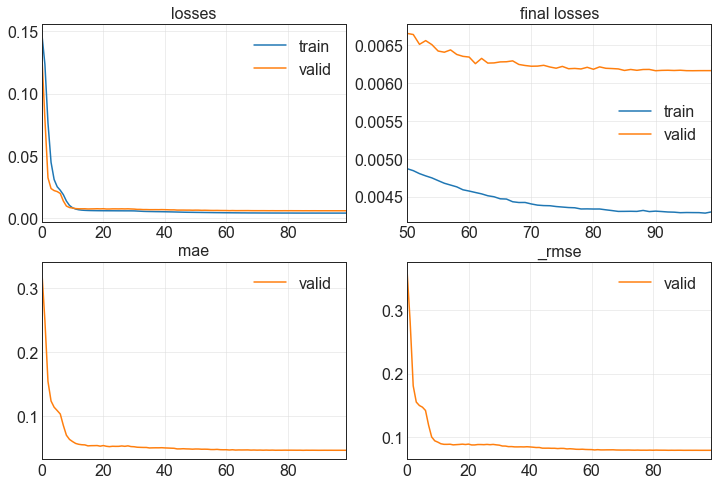

50.61403512954712                                                                                                      
[0.0042996178381145, 0.006163508165627718, 0.04604053497314453, 0.07850801199674606]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 39%|███████████████▌                        | 39/100 [1:18:41<1:43:57, 102.25s/trial, best loss: 0.001899293391034007]

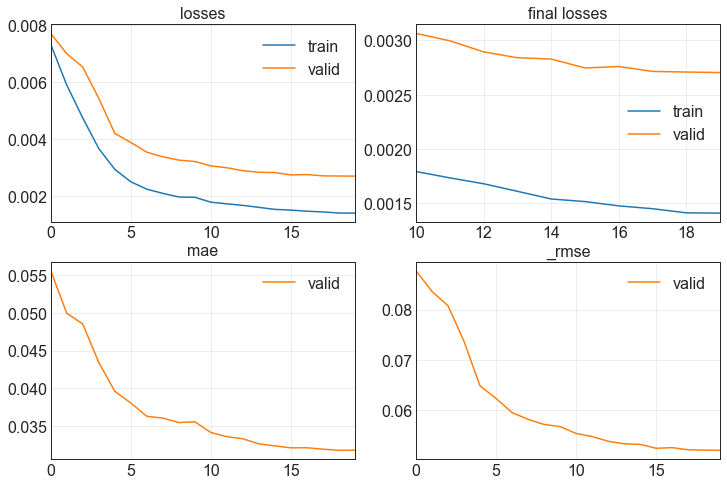

44.58735513687134                                                                                                      
[0.0014113939832895994, 0.0027040494605898857, 0.031806472688913345, 0.052000485360622406]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 40%|████████████████▍                        | 40/100 [1:19:27<1:25:16, 85.28s/trial, best loss: 0.001899293391034007]

No improvement since epoch 9: early stopping                                                                           
 40%|████████████████▍                        | 40/100 [1:20:21<1:25:16, 85.28s/trial, best loss: 0.001899293391034007]

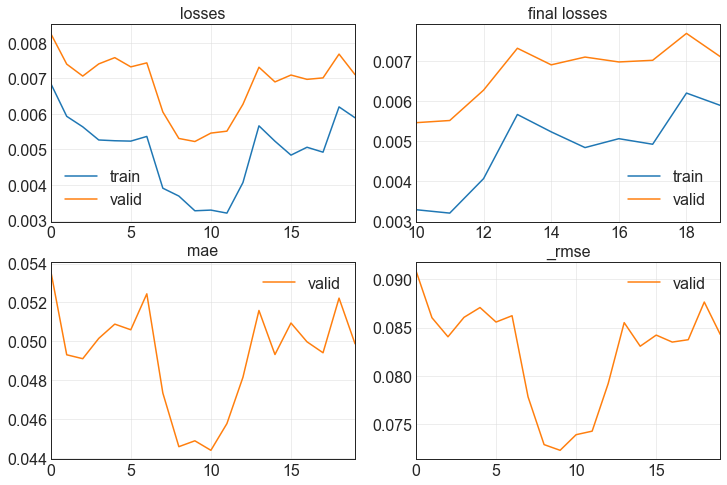

53.956369400024414                                                                                                     
[0.005890292581170797, 0.00710323266685009, 0.0498686209321022, 0.08428067713975906]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 41%|████████████████▊                        | 41/100 [1:20:22<1:14:56, 76.22s/trial, best loss: 0.001899293391034007]

No improvement since epoch 61: early stopping                                                                          
 41%|████████████████▊                        | 41/100 [1:22:50<1:14:56, 76.22s/trial, best loss: 0.001899293391034007]

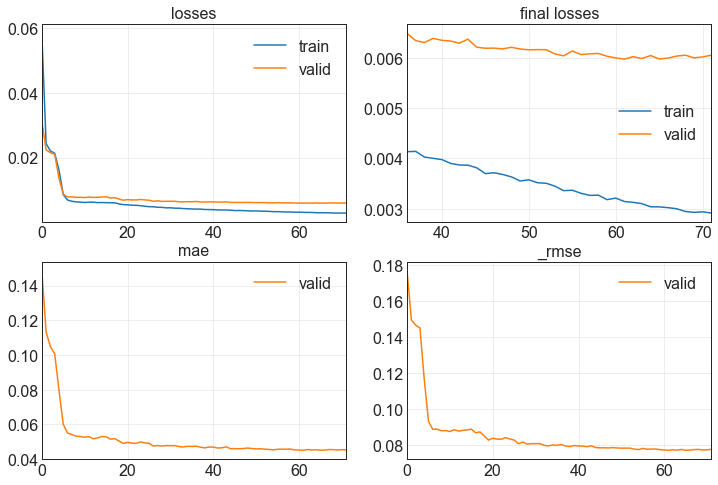

148.55822253227234                                                                                                     
[0.0029133427888154984, 0.006053618621081114, 0.0453946590423584, 0.07780499756336212]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 42%|█████████████████▏                       | 42/100 [1:22:52<1:34:58, 98.25s/trial, best loss: 0.001899293391034007]

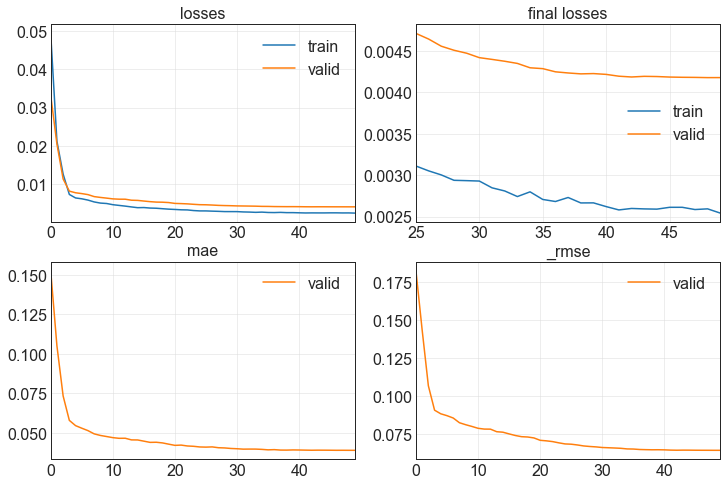

117.74084949493408                                                                                                     
[0.0025434379931539297, 0.004177426919341087, 0.038880329579114914, 0.06463301926851273]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 43%|█████████████████▏                      | 43/100 [1:24:51<1:39:13, 104.44s/trial, best loss: 0.001899293391034007]

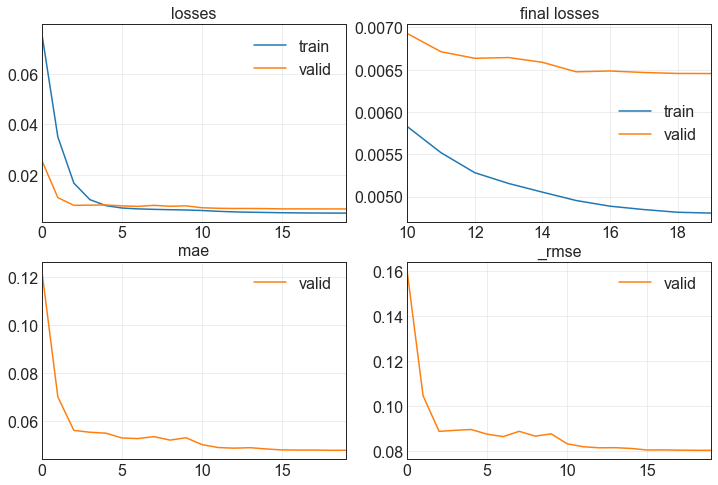

12.582618713378906                                                                                                     
[0.004804833792150021, 0.00645520118996501, 0.04779631271958351, 0.08034426718950272]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 44%|██████████████████                       | 44/100 [1:25:04<1:12:04, 77.22s/trial, best loss: 0.001899293391034007]

No improvement since epoch 3: early stopping                                                                           
 44%|██████████████████                       | 44/100 [1:25:35<1:12:04, 77.22s/trial, best loss: 0.001899293391034007]

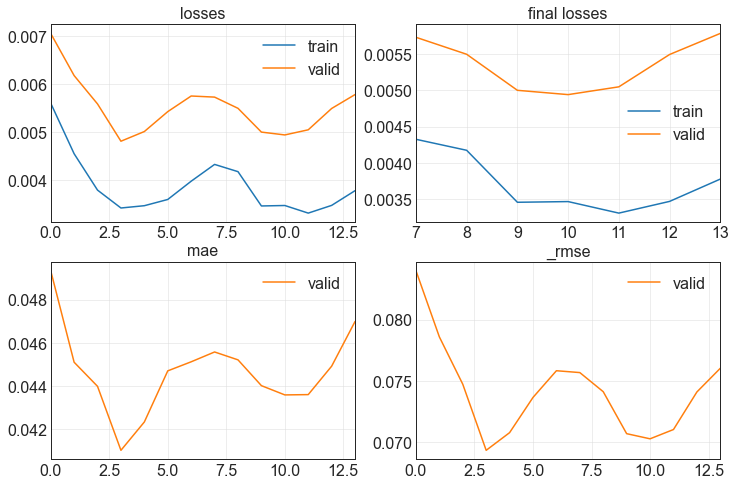

31.061137914657593                                                                                                     
[0.0037782888393849134, 0.005779860075563192, 0.0469866618514061, 0.07602539658546448]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 45%|███████████████████▎                       | 45/100 [1:25:37<58:23, 63.70s/trial, best loss: 0.001899293391034007]

No improvement since epoch 54: early stopping                                                                          
 45%|███████████████████▎                       | 45/100 [1:30:43<58:23, 63.70s/trial, best loss: 0.001899293391034007]

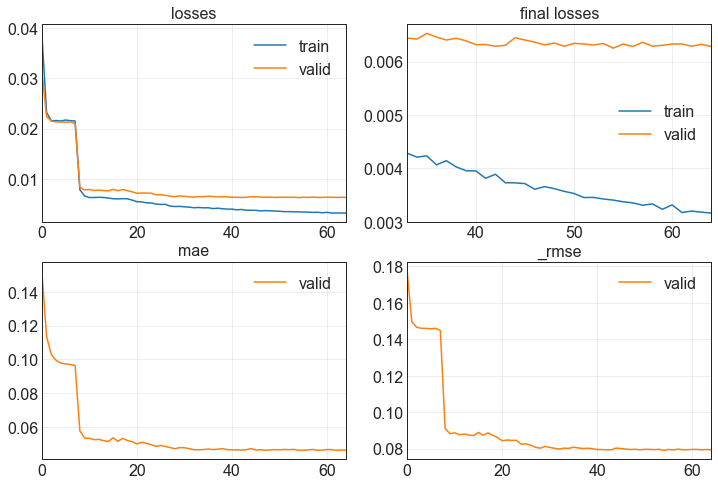

306.4302866458893                                                                                                      
[0.0031649721786379814, 0.006282408721745014, 0.04637937620282173, 0.07926163822412491]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 46%|██████████████████▍                     | 46/100 [1:30:44<2:03:09, 136.85s/trial, best loss: 0.001899293391034007]

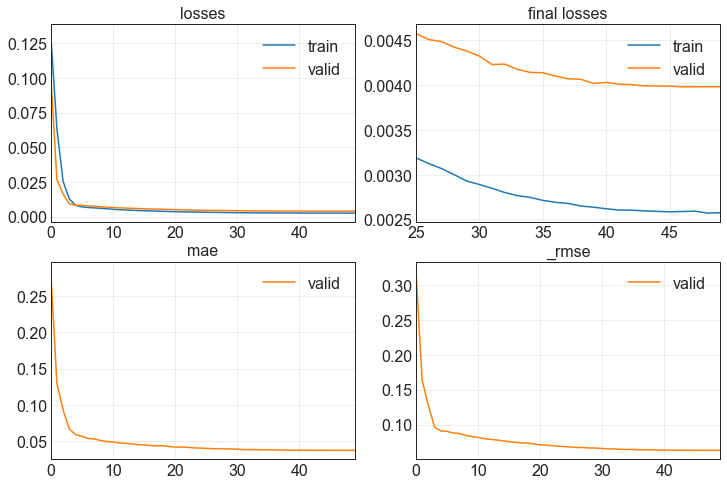

40.255090951919556                                                                                                     
[0.0025756729301065207, 0.003983179572969675, 0.0373990423977375, 0.06311243027448654]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 47%|██████████████████▊                     | 47/100 [1:31:25<1:35:35, 108.22s/trial, best loss: 0.001899293391034007]

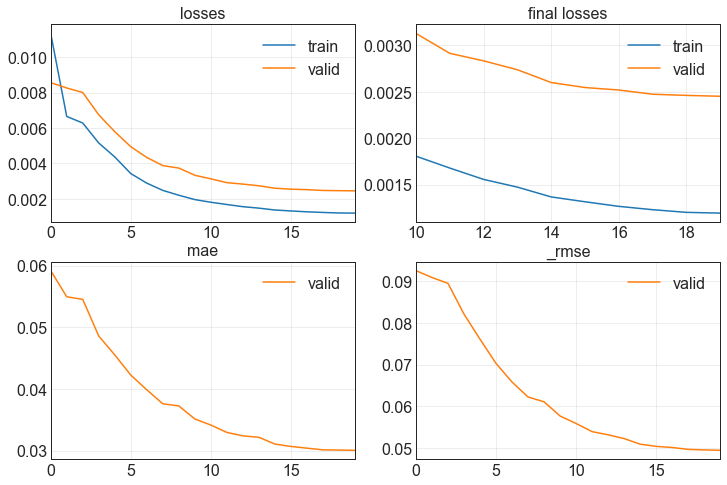

29.623612642288208                                                                                                     
[0.0011946100275963545, 0.0024510740768164396, 0.03004995547235012, 0.04950832575559616]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 48%|███████████████████▋                     | 48/100 [1:31:56<1:13:38, 84.97s/trial, best loss: 0.001899293391034007]

No improvement since epoch 22: early stopping                                                                          
 48%|███████████████████▋                     | 48/100 [1:32:16<1:13:38, 84.97s/trial, best loss: 0.001899293391034007]

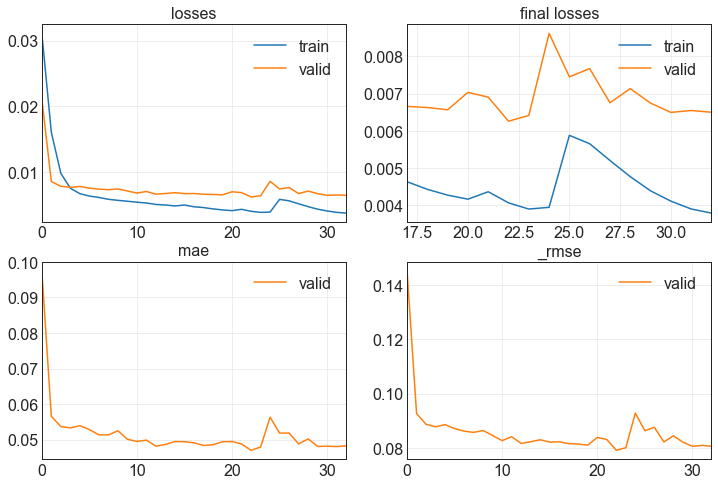

19.906557083129883                                                                                                     
[0.0037892034742981195, 0.006500552874058485, 0.04824468120932579, 0.0806260034441948]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 49%|█████████████████████                      | 49/100 [1:32:17<55:55, 65.79s/trial, best loss: 0.001899293391034007]

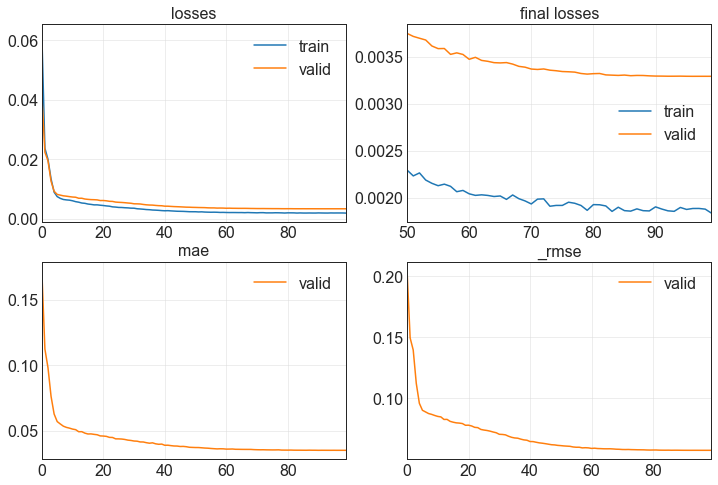

228.9323787689209                                                                                                      
[0.0018358946545049548, 0.0032902350649237633, 0.034938547760248184, 0.05736057087779045]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 50%|████████████████████                    | 50/100 [1:36:07<1:35:53, 115.08s/trial, best loss: 0.001899293391034007]

No improvement since epoch 24: early stopping                                                                          
 50%|████████████████████                    | 50/100 [1:37:06<1:35:53, 115.08s/trial, best loss: 0.001899293391034007]

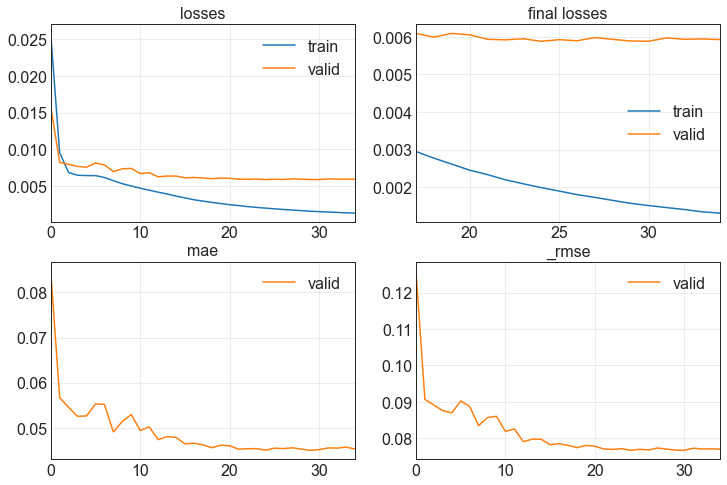

59.20380210876465                                                                                                      
[0.001314351218752563, 0.005926521494984627, 0.045311618596315384, 0.07698390632867813]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 51%|████████████████████▉                    | 51/100 [1:37:08<1:20:34, 98.66s/trial, best loss: 0.001899293391034007]

No improvement since epoch 29: early stopping                                                                          
 51%|████████████████████▉                    | 51/100 [1:39:52<1:20:34, 98.66s/trial, best loss: 0.001899293391034007]

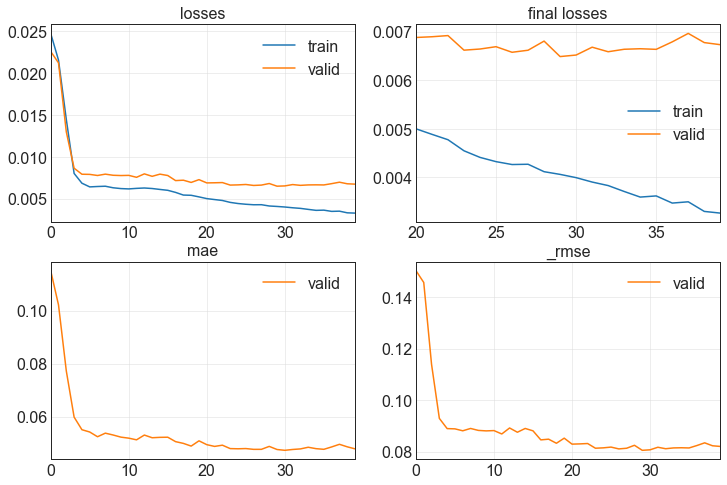

164.95884323120117                                                                                                     
[0.0032645673491060734, 0.006729871965944767, 0.04786361753940582, 0.08203580230474472]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 52%|████████████████████▊                   | 52/100 [1:39:54<1:35:06, 118.88s/trial, best loss: 0.001899293391034007]

No improvement since epoch 1: early stopping                                                                           
 52%|████████████████████▊                   | 52/100 [1:40:01<1:35:06, 118.88s/trial, best loss: 0.001899293391034007]

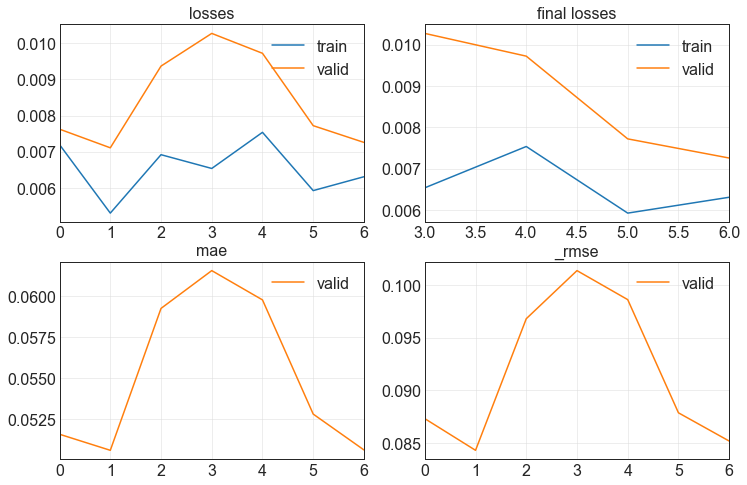

7.773179292678833                                                                                                      
[0.00630610715597868, 0.007255587726831436, 0.05062347277998924, 0.08517973870038986]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 53%|█████████████████████▋                   | 53/100 [1:40:03<1:07:16, 85.88s/trial, best loss: 0.001899293391034007]

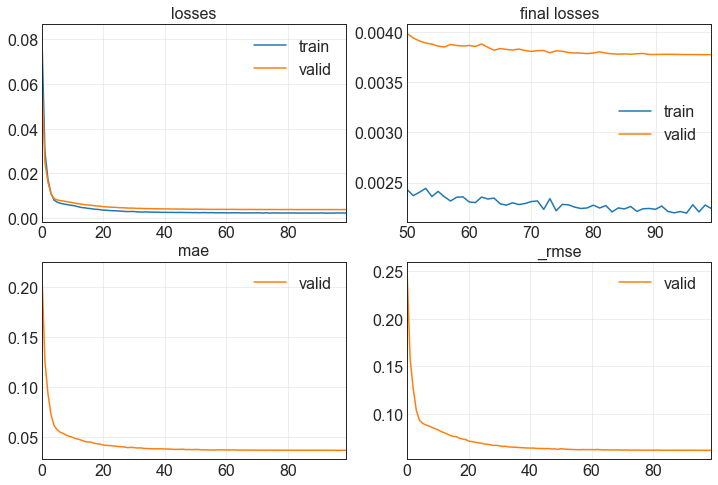

275.70718359947205                                                                                                     
[0.0022401793394237757, 0.003776844125241041, 0.03677832707762718, 0.06145603954792023]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 54%|█████████████████████▌                  | 54/100 [1:44:39<1:49:45, 143.15s/trial, best loss: 0.001899293391034007]

No improvement since epoch 43: early stopping                                                                          
 54%|█████████████████████▌                  | 54/100 [1:45:19<1:49:45, 143.15s/trial, best loss: 0.001899293391034007]

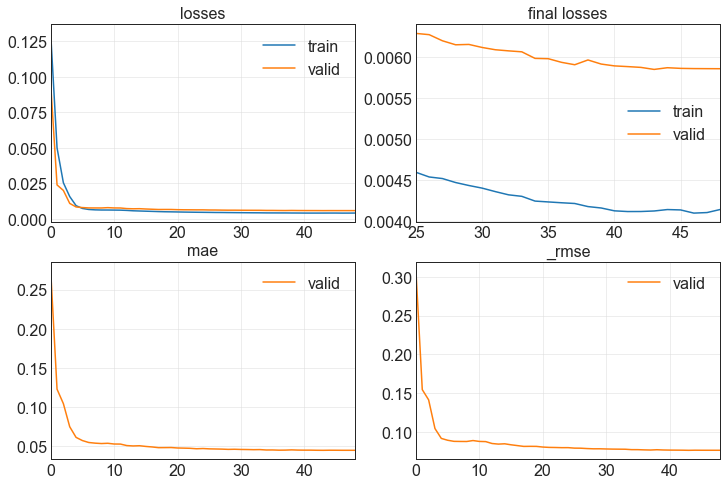

39.72866415977478                                                                                                      
[0.004144726786762476, 0.005861053243279457, 0.04466025158762932, 0.07655751705169678]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 55%|██████████████████████                  | 55/100 [1:45:20<1:24:21, 112.47s/trial, best loss: 0.001899293391034007]

No improvement since epoch 83: early stopping                                                                          
 55%|██████████████████████                  | 55/100 [1:48:55<1:24:21, 112.47s/trial, best loss: 0.001899293391034007]

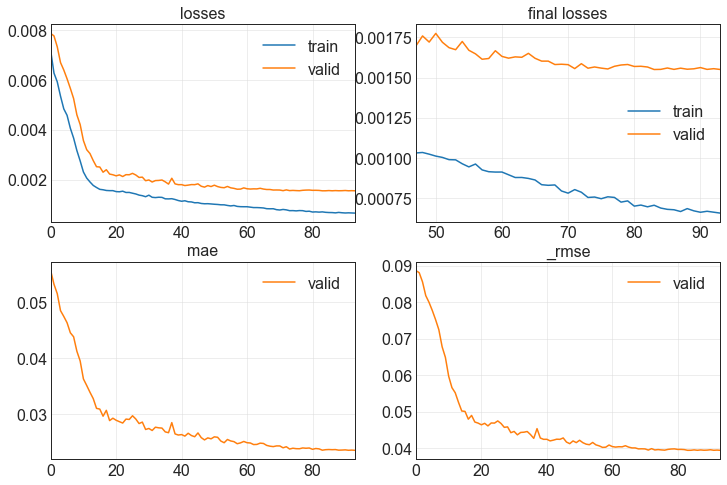

214.78903007507324                                                                                                     
[0.0006562331691384315, 0.0015502215828746557, 0.023495052009820938, 0.03937285766005516]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 56%|█████████████████████▊                 | 56/100 [1:48:56<1:45:13, 143.50s/trial, best loss: 0.0015502215828746557]

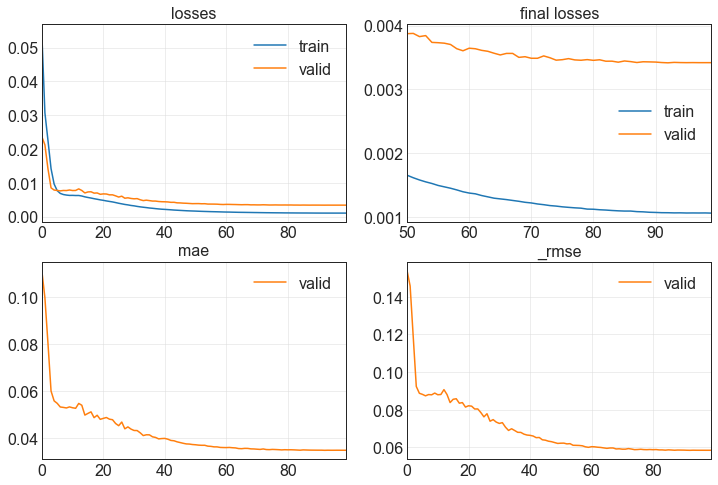

53.95347261428833                                                                                                      
[0.0010632954072207212, 0.0034187145065516233, 0.03472185507416725, 0.058469776064157486]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 57%|██████████████████████▏                | 57/100 [1:49:51<1:23:50, 116.99s/trial, best loss: 0.0015502215828746557]

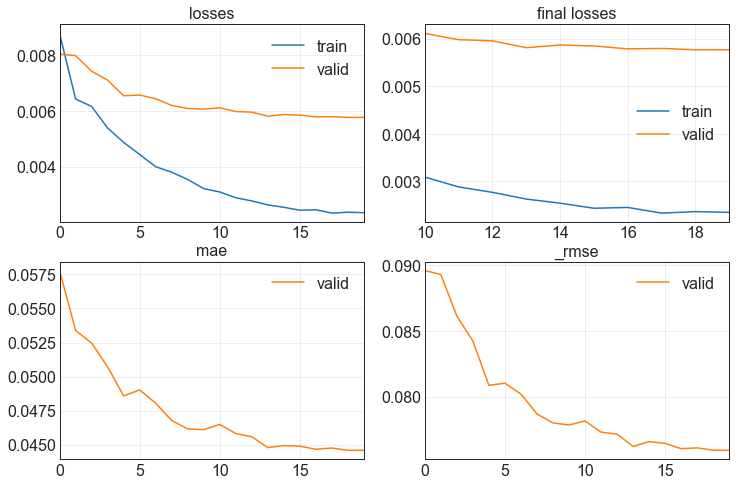

111.49540448188782                                                                                                     
[0.0023502300027757883, 0.0057630087248981, 0.0445854514837265, 0.07591447979211807]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 58%|██████████████████████▌                | 58/100 [1:51:44<1:20:58, 115.67s/trial, best loss: 0.0015502215828746557]

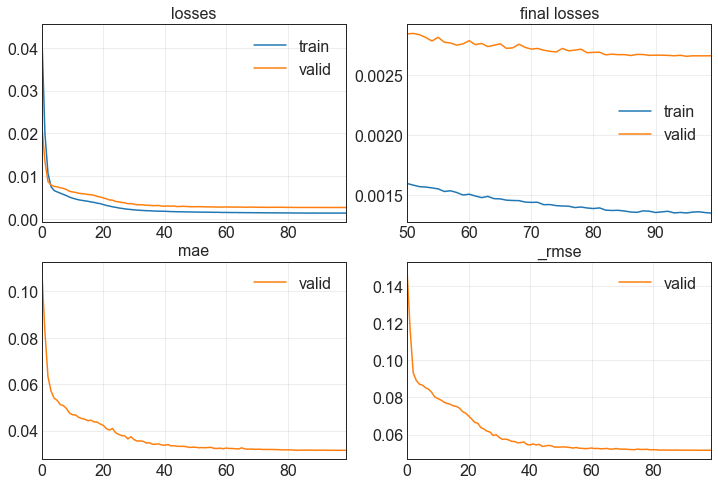

57.64241862297058                                                                                                      
[0.0013475186424329877, 0.0026637609116733074, 0.03154066577553749, 0.05161163583397865]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 10}
GRU                                                                                                                    
 59%|███████████████████████▌                | 59/100 [1:52:43<1:07:22, 98.60s/trial, best loss: 0.0015502215828746557]

No improvement since epoch 16: early stopping                                                                          
 59%|███████████████████████▌                | 59/100 [1:54:33<1:07:22, 98.60s/trial, best loss: 0.0015502215828746557]

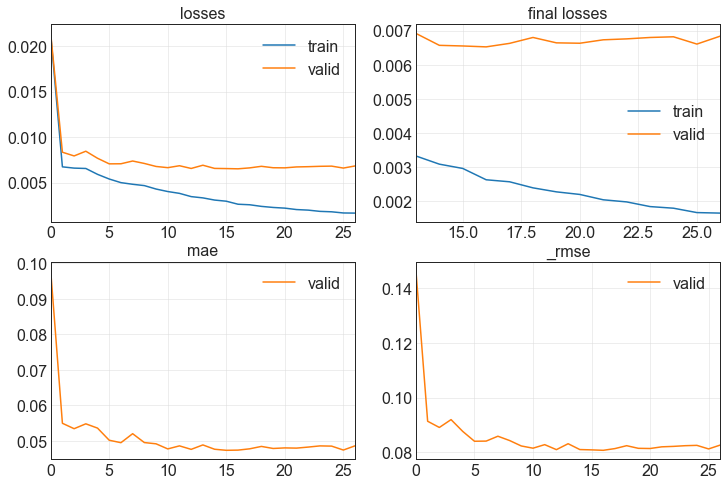

110.82308506965637                                                                                                     
[0.0016562030650675297, 0.006838228087872267, 0.04861031845211983, 0.08269357681274414]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 60%|███████████████████████▍               | 60/100 [1:54:35<1:08:23, 102.60s/trial, best loss: 0.0015502215828746557]

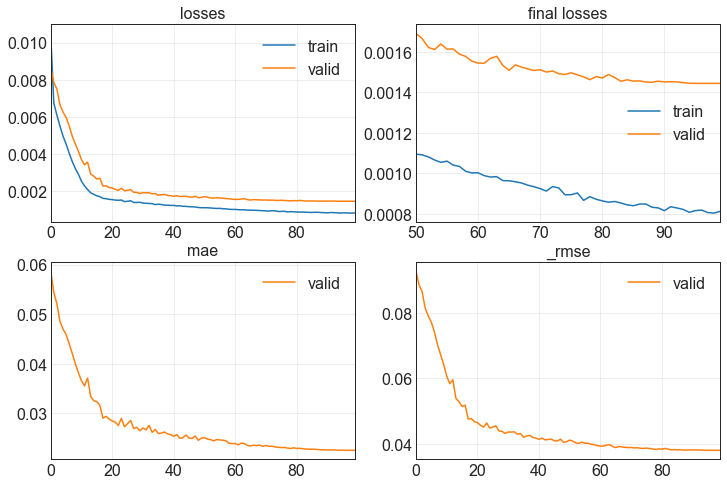

147.25280094146729                                                                                                     
[0.0008132384391501546, 0.0014441880630329251, 0.022541746497154236, 0.03800247237086296]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 61%|███████████████████████▊               | 61/100 [1:57:03<1:15:36, 116.32s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 82: early stopping                                                                          
 61%|███████████████████████▊               | 61/100 [2:00:09<1:15:36, 116.32s/trial, best loss: 0.0014441880630329251]

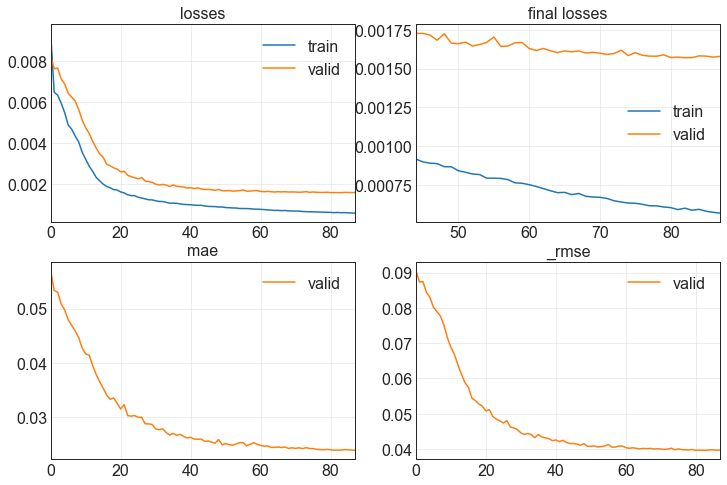

185.97229528427124                                                                                                     
[0.0005695801228284836, 0.0015788540476933122, 0.023955397307872772, 0.039734795689582825]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 62%|████████████████████████▏              | 62/100 [2:00:10<1:27:07, 137.56s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 93: early stopping                                                                          
 62%|████████████████████████▏              | 62/100 [2:02:14<1:27:07, 137.56s/trial, best loss: 0.0014441880630329251]

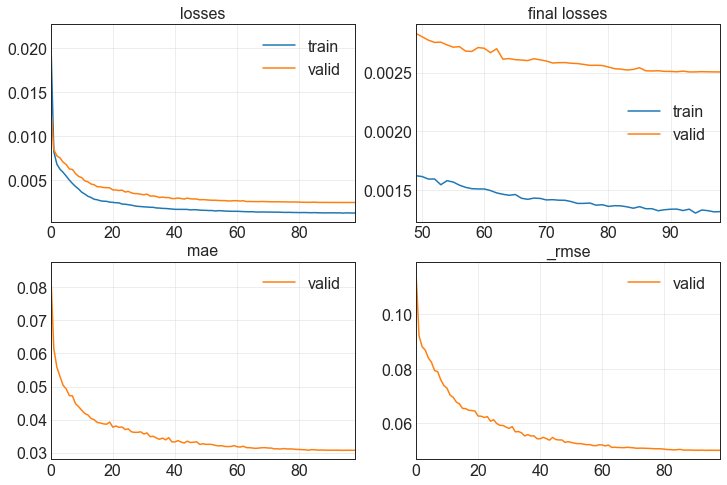

124.72792625427246                                                                                                     
[0.0013174985069781542, 0.0025056302547454834, 0.030715305358171463, 0.050056274980306625]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 63%|████████████████████████▌              | 63/100 [2:02:16<1:22:39, 134.04s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 23: early stopping                                                                          
 63%|████████████████████████▌              | 63/100 [2:03:52<1:22:39, 134.04s/trial, best loss: 0.0014441880630329251]

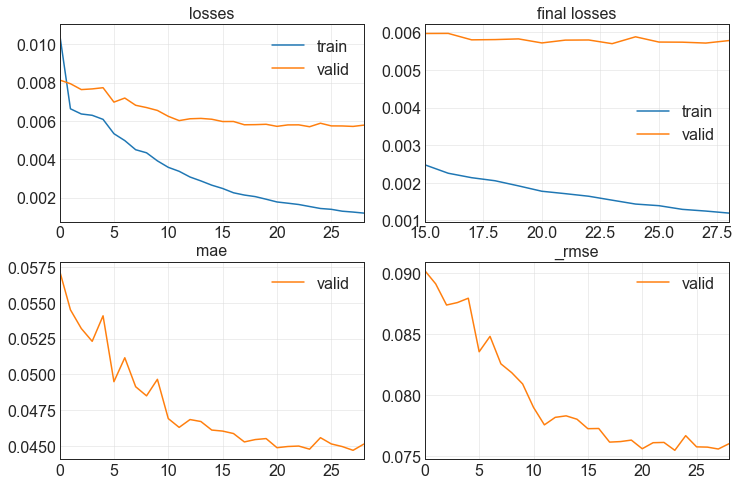

96.88241291046143                                                                                                      
[0.0011944373836740851, 0.0057808938436210155, 0.04515056684613228, 0.07603219151496887]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 64%|████████████████████████▉              | 64/100 [2:03:54<1:13:56, 123.23s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 71: early stopping                                                                          
 64%|████████████████████████▉              | 64/100 [2:05:32<1:13:56, 123.23s/trial, best loss: 0.0014441880630329251]

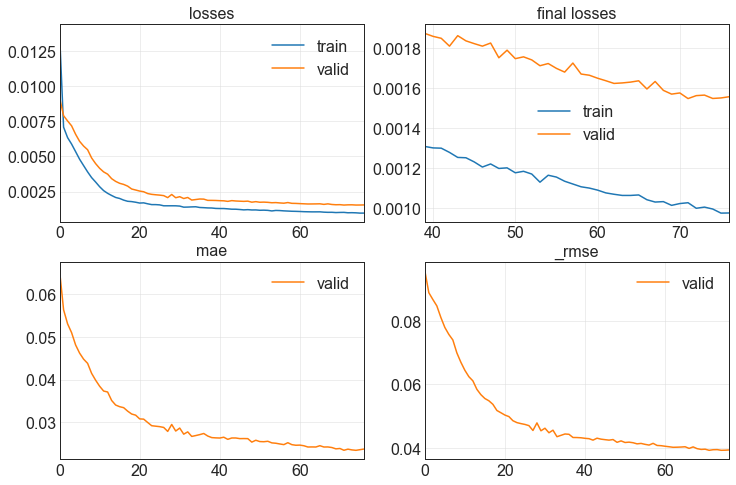

98.03975129127502                                                                                                      
[0.0009758268133737147, 0.001556037925183773, 0.023778466507792473, 0.03944665193557739]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 65%|█████████████████████████▎             | 65/100 [2:05:33<1:07:40, 116.00s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 87: early stopping                                                                          
 65%|█████████████████████████▎             | 65/100 [2:07:31<1:07:40, 116.00s/trial, best loss: 0.0014441880630329251]

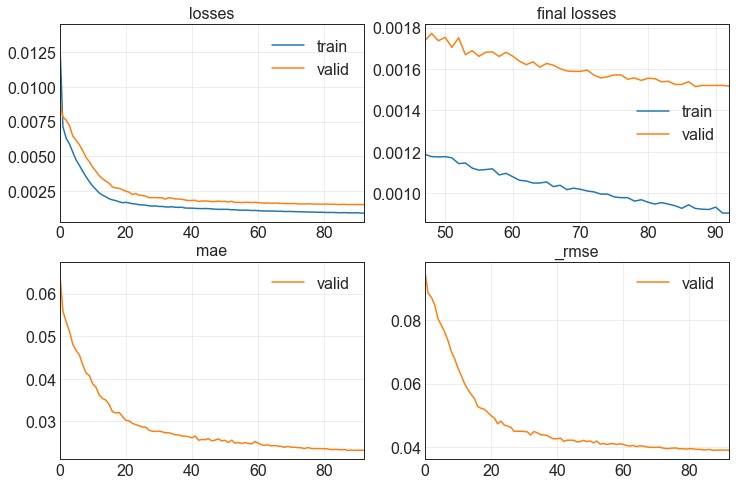

118.54528951644897                                                                                                     
[0.0009033469832502306, 0.0015178307658061385, 0.023240678012371063, 0.03895934298634529]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 66%|█████████████████████████▋             | 66/100 [2:07:33<1:06:21, 117.09s/trial, best loss: 0.0014441880630329251]

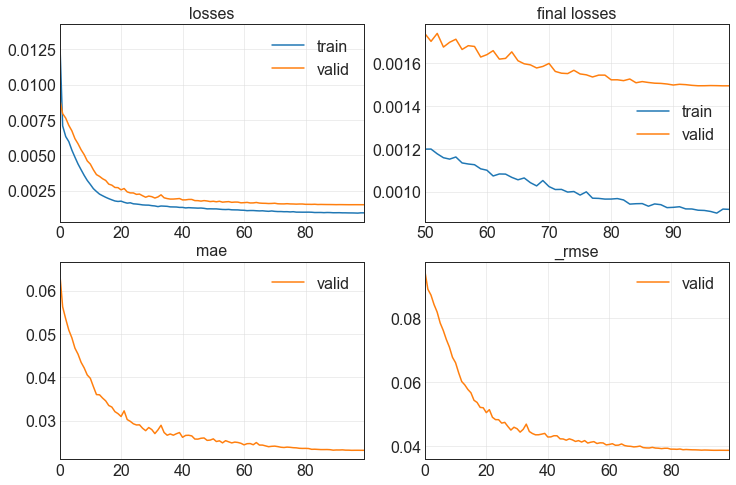

130.6755657196045                                                                                                      
[0.0009175252052955329, 0.0014947338495403528, 0.02315678820014, 0.038661789149045944]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 67%|██████████████████████████▏            | 67/100 [2:09:44<1:06:49, 121.50s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 94: early stopping                                                                          
 67%|██████████████████████████▏            | 67/100 [2:11:57<1:06:49, 121.50s/trial, best loss: 0.0014441880630329251]

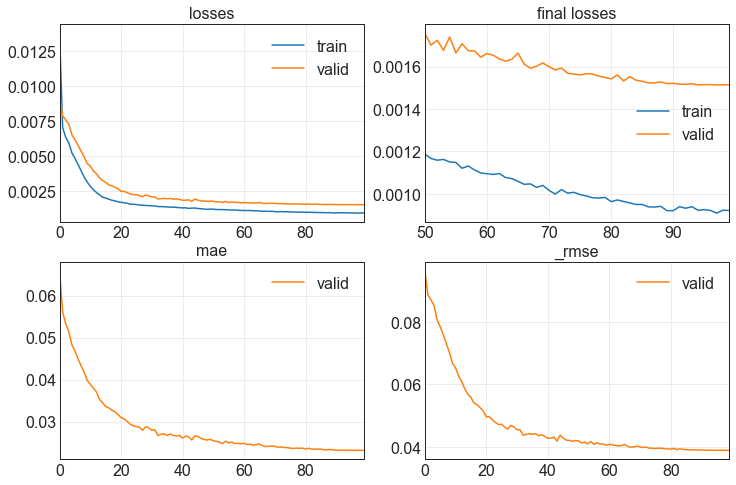

133.1483438014984                                                                                                      
[0.0009208692354150116, 0.0015143334167078137, 0.023197926580905914, 0.03891443833708763]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 68%|██████████████████████████▌            | 68/100 [2:11:59<1:06:50, 125.33s/trial, best loss: 0.0014441880630329251]

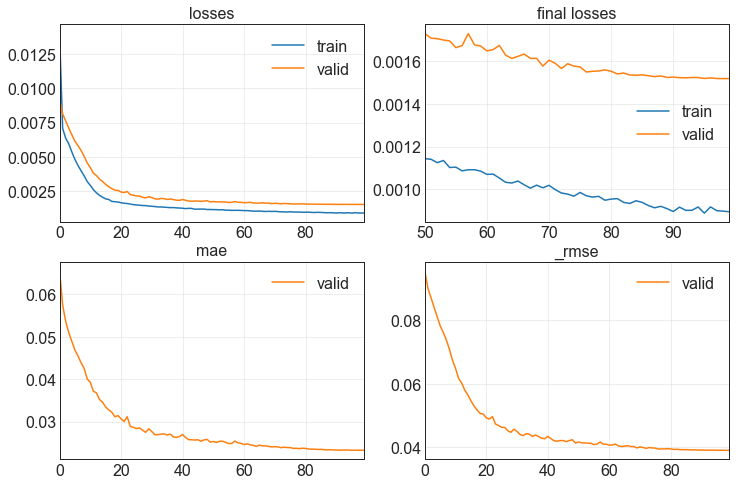

138.9908149242401                                                                                                      
[0.0008936968515627086, 0.0015195304295048118, 0.02327210269868374, 0.038981154561042786]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 69%|██████████████████████████▉            | 69/100 [2:14:19<1:07:02, 129.76s/trial, best loss: 0.0014441880630329251]

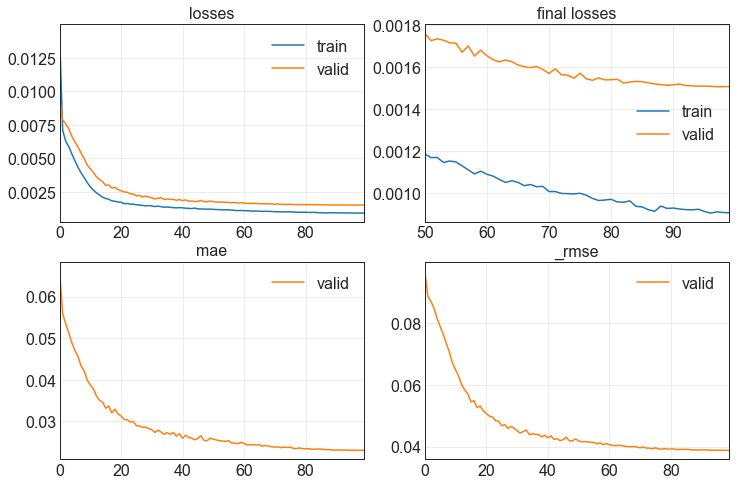

137.13971066474915                                                                                                     
[0.0009086650097742677, 0.001507429638877511, 0.023062950000166893, 0.0388256311416626]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 70%|███████████████████████████▎           | 70/100 [2:16:37<1:06:09, 132.32s/trial, best loss: 0.0014441880630329251]

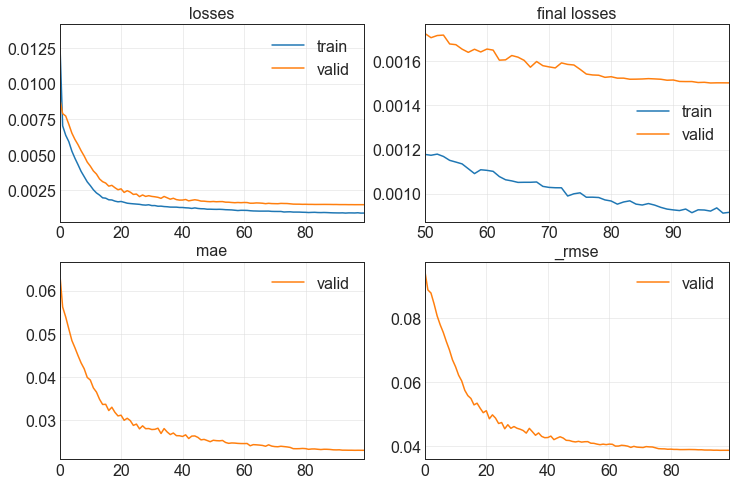

137.71017384529114                                                                                                     
[0.0009150021942332387, 0.0015023639425635338, 0.023018229752779007, 0.038760337978601456]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 71%|███████████████████████████▋           | 71/100 [2:18:56<1:04:54, 134.28s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 87: early stopping                                                                          
 71%|███████████████████████████▋           | 71/100 [2:21:04<1:04:54, 134.28s/trial, best loss: 0.0014441880630329251]

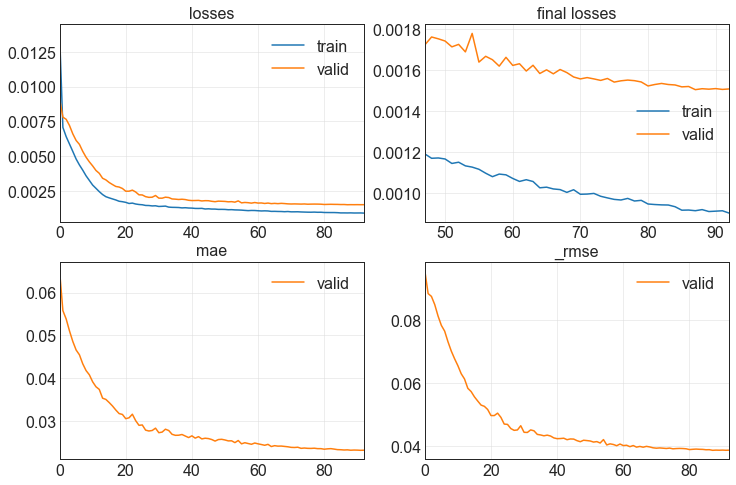

128.07930326461792                                                                                                     
[0.000900941900908947, 0.0015077907592058182, 0.023227734491229057, 0.03883028030395508]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 72%|████████████████████████████           | 72/100 [2:21:05<1:01:57, 132.77s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 36: early stopping                                                                          
 72%|████████████████████████████           | 72/100 [2:22:00<1:01:57, 132.77s/trial, best loss: 0.0014441880630329251]

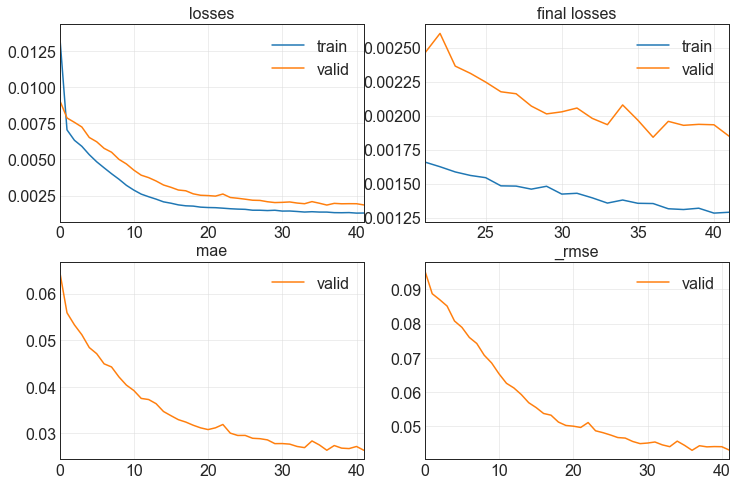

55.441115856170654                                                                                                     
[0.0012891318183392286, 0.0018482309533283114, 0.02638021484017372, 0.04299106076359749]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 73%|█████████████████████████████▉           | 73/100 [2:22:02<49:27, 109.91s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 86: early stopping                                                                          
 73%|█████████████████████████████▉           | 73/100 [2:25:24<49:27, 109.91s/trial, best loss: 0.0014441880630329251]

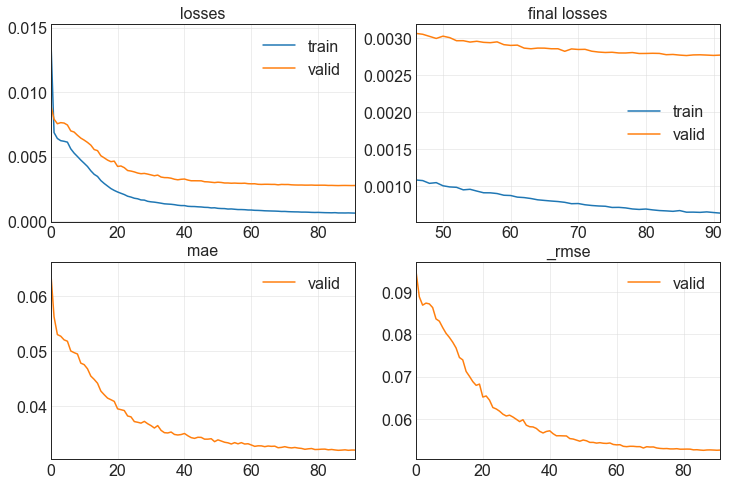

202.30588006973267                                                                                                     
[0.0006297086947597563, 0.0027676569297909737, 0.03211463987827301, 0.05260852724313736]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 74%|██████████████████████████████▎          | 74/100 [2:25:25<59:47, 137.97s/trial, best loss: 0.0014441880630329251]

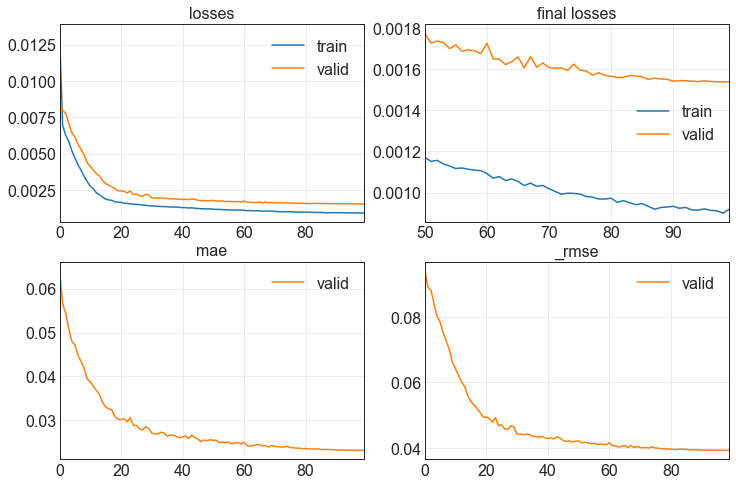

134.50474214553833                                                                                                     
[0.0009189355769194663, 0.0015380923869088292, 0.023183295503258705, 0.03921852633357048]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 75%|██████████████████████████████▊          | 75/100 [2:27:41<57:12, 137.28s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 4: early stopping                                                                           
 75%|██████████████████████████████▊          | 75/100 [2:28:12<57:12, 137.28s/trial, best loss: 0.0014441880630329251]

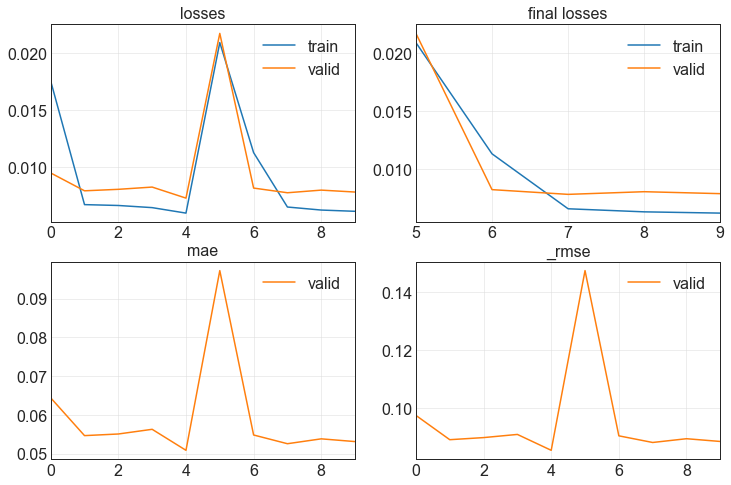

31.857380390167236                                                                                                     
[0.006166303995996714, 0.007849792018532753, 0.05313115566968918, 0.0885990709066391]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 76%|███████████████████████████████▏         | 76/100 [2:28:14<42:24, 106.03s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 83: early stopping                                                                          
 76%|███████████████████████████████▏         | 76/100 [2:30:55<42:24, 106.03s/trial, best loss: 0.0014441880630329251]

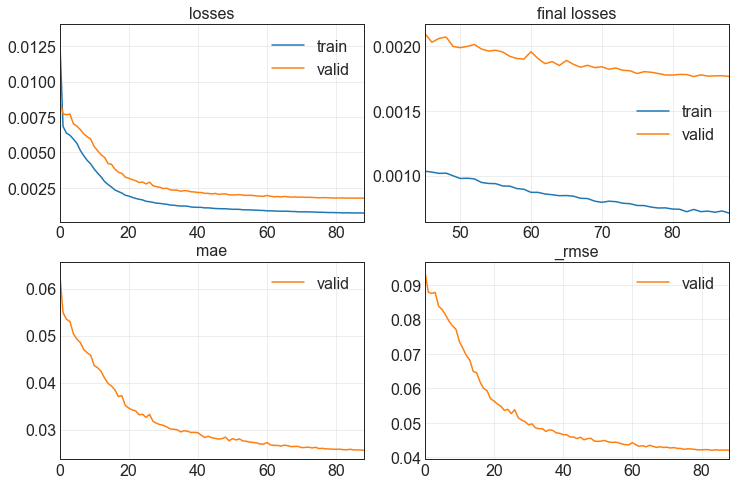

161.4081311225891                                                                                                      
[0.0007101210649125278, 0.001767306705005467, 0.02557661198079586, 0.04203934594988823]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 77%|███████████████████████████████▌         | 77/100 [2:30:57<47:08, 122.99s/trial, best loss: 0.0014441880630329251]

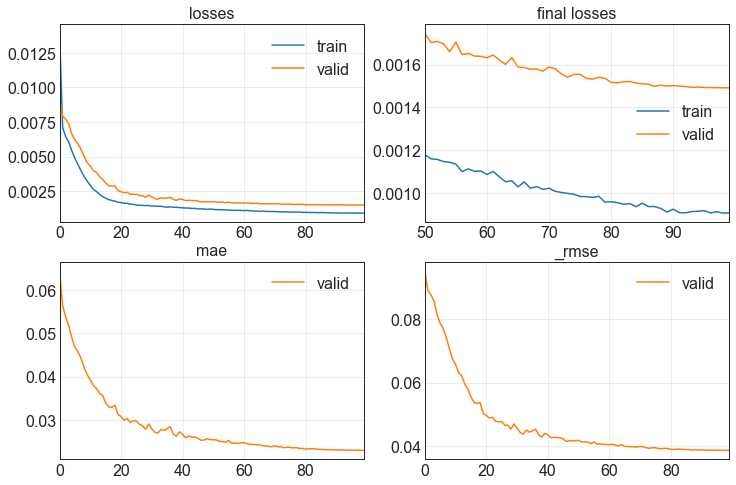

137.2823302745819                                                                                                      
[0.0009081357857212424, 0.001491556060500443, 0.022951733320951462, 0.03862066566944122]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 78%|███████████████████████████████▉         | 78/100 [2:33:15<46:47, 127.62s/trial, best loss: 0.0014441880630329251]

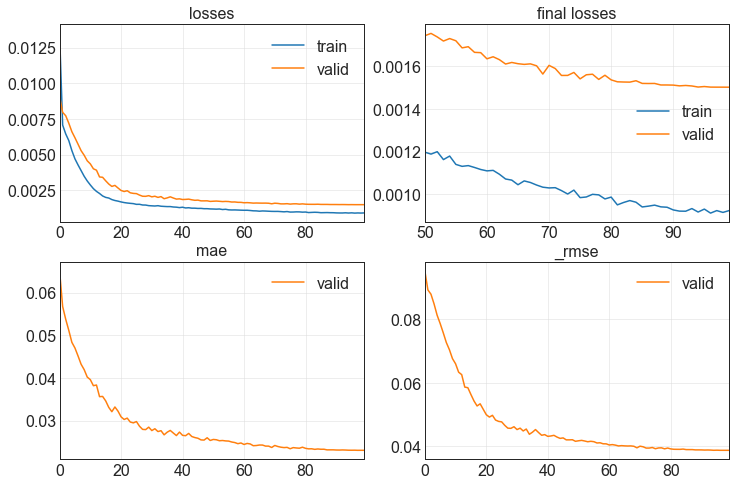

137.80514335632324                                                                                                     
[0.0009234773460775614, 0.0015024540480226278, 0.023056117817759514, 0.03876150771975517]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 79%|████████████████████████████████▍        | 79/100 [2:35:34<45:51, 131.03s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 7: early stopping                                                                           
 79%|████████████████████████████████▍        | 79/100 [2:36:09<45:51, 131.03s/trial, best loss: 0.0014441880630329251]

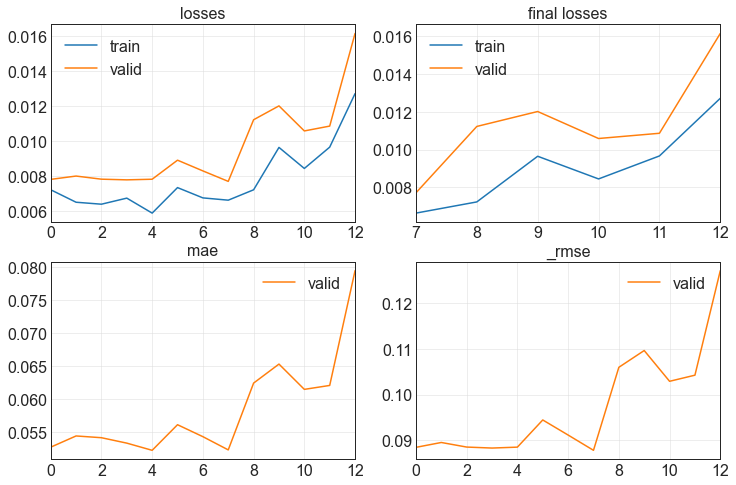

35.17666006088257                                                                                                      
[0.012721692211925983, 0.016156742349267006, 0.07948602735996246, 0.12710916996002197]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 80%|████████████████████████████████▊        | 80/100 [2:36:10<34:12, 102.63s/trial, best loss: 0.0014441880630329251]

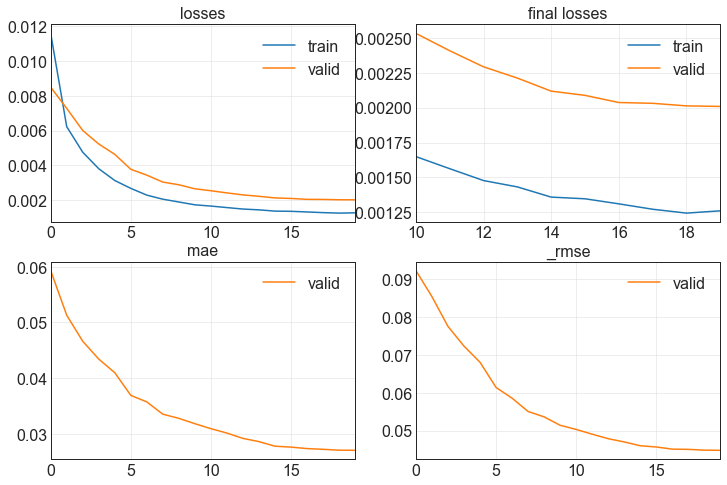

27.496479749679565                                                                                                     
[0.001260036719031632, 0.002008868148550391, 0.027016984298825264, 0.044820405542850494]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [2:36:39<25:28, 80.44s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 69: early stopping                                                                          
 81%|██████████████████████████████████        | 81/100 [2:39:26<25:28, 80.44s/trial, best loss: 0.0014441880630329251]

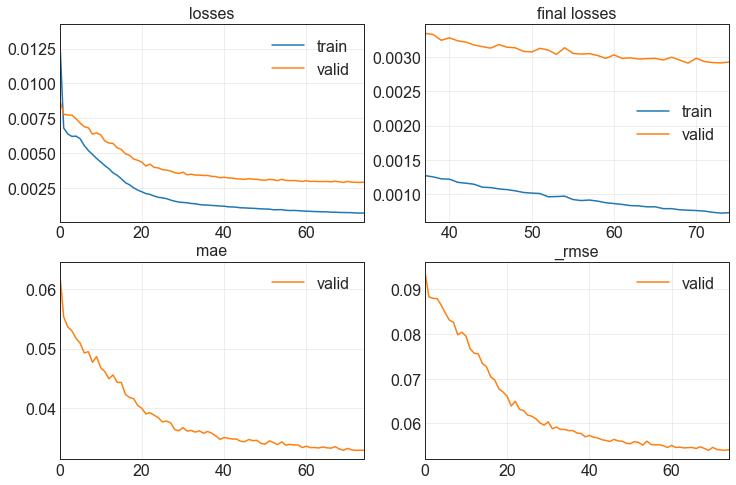

167.4440906047821                                                                                                      
[0.0007249663467518985, 0.0029308563098311424, 0.032859113067388535, 0.05413738638162613]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 82%|█████████████████████████████████▌       | 82/100 [2:39:28<32:03, 106.88s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 32: early stopping                                                                          
 82%|█████████████████████████████████▌       | 82/100 [2:40:08<32:03, 106.88s/trial, best loss: 0.0014441880630329251]

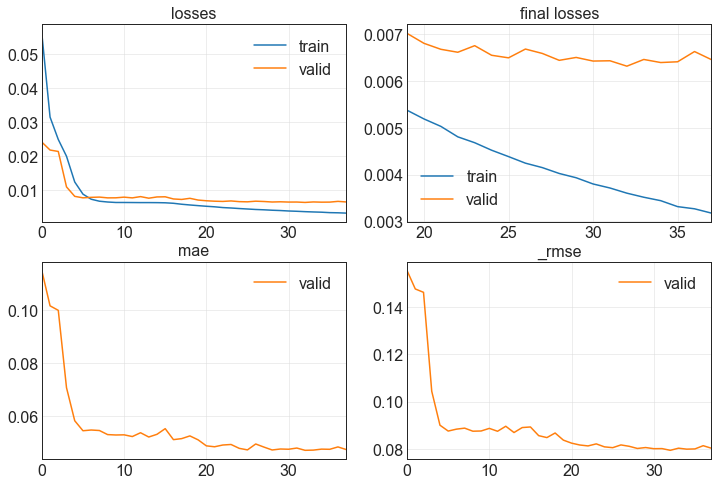

40.59771990776062                                                                                                      
[0.003175552934408188, 0.006460461765527725, 0.04728195443749428, 0.0803770050406456]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [2:40:09<24:44, 87.35s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 14: early stopping                                                                          
 83%|██████████████████████████████████▊       | 83/100 [2:40:37<24:44, 87.35s/trial, best loss: 0.0014441880630329251]

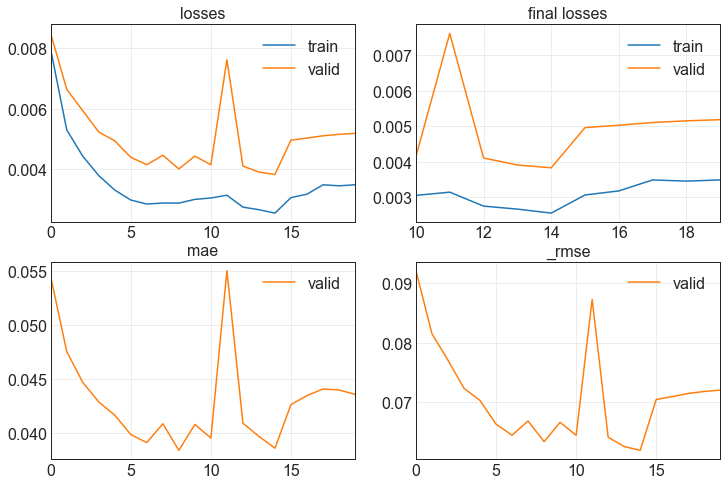

27.82455086708069                                                                                                      
[0.0034912724513560534, 0.005189330317080021, 0.04359349235892296, 0.07203700393438339]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 84%|███████████████████████████████████▎      | 84/100 [2:40:38<18:37, 69.84s/trial, best loss: 0.0014441880630329251]

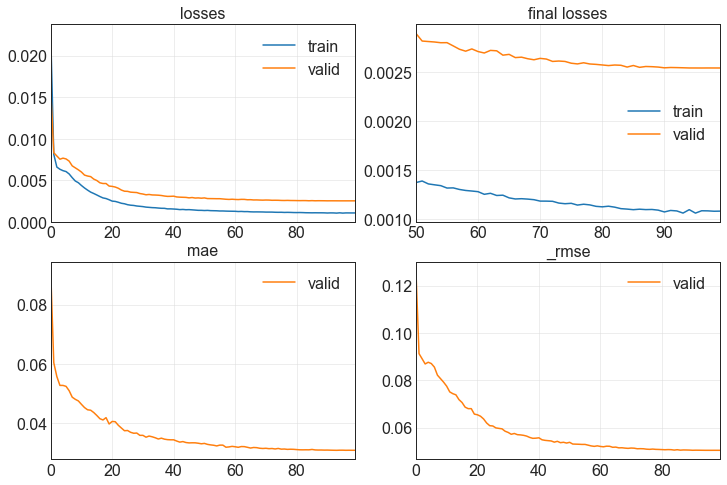

179.38678097724915                                                                                                     
[0.0010838740272447467, 0.002538941567763686, 0.030953172594308853, 0.0503879114985466]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 85%|██████████████████████████████████▊      | 85/100 [2:43:39<25:45, 103.05s/trial, best loss: 0.0014441880630329251]

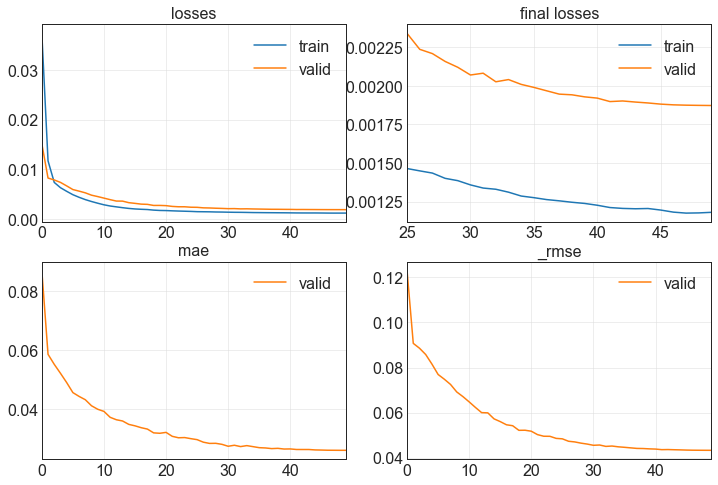

37.6009886264801                                                                                                       
[0.001180559047497809, 0.0018720091320574284, 0.026070337742567062, 0.043266721069812775]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 86%|████████████████████████████████████      | 86/100 [2:44:18<19:32, 83.78s/trial, best loss: 0.0014441880630329251]

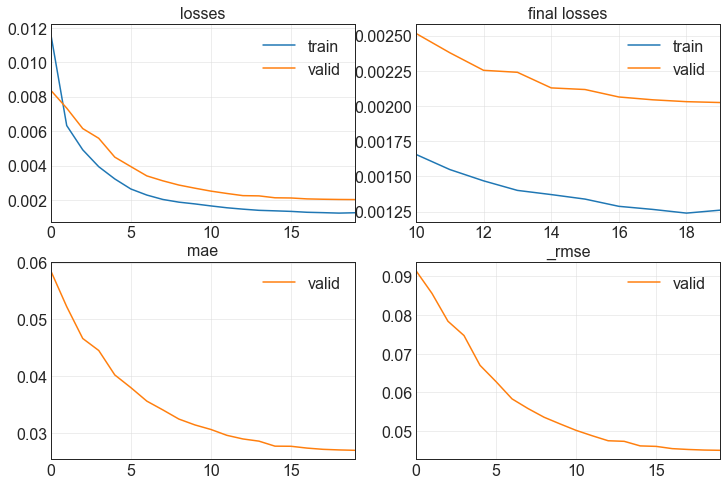

27.816750288009644                                                                                                     
[0.0012601539492607117, 0.0020248224027454853, 0.026993045583367348, 0.04499802365899086]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 87%|████████████████████████████████████▌     | 87/100 [2:44:47<14:35, 67.35s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 7: early stopping                                                                           
 87%|████████████████████████████████████▌     | 87/100 [2:44:56<14:35, 67.35s/trial, best loss: 0.0014441880630329251]

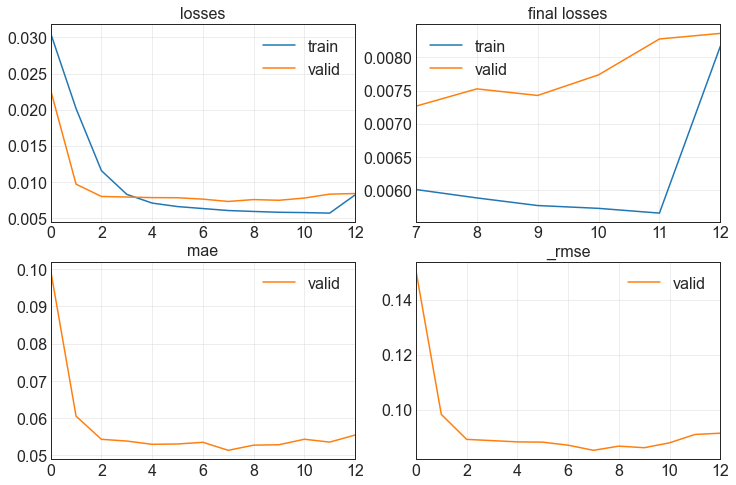

9.75982117652893                                                                                                       
[0.00816852692514658, 0.00836386438459158, 0.05540207028388977, 0.0914541706442833]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 88%|████████████████████████████████████▉     | 88/100 [2:44:58<10:04, 50.41s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 89: early stopping                                                                          
 88%|████████████████████████████████████▉     | 88/100 [2:48:25<10:04, 50.41s/trial, best loss: 0.0014441880630329251]

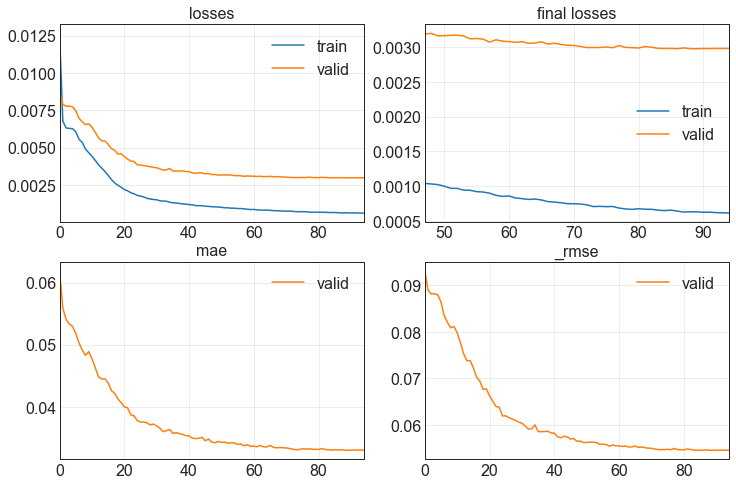

208.12992477416992                                                                                                     
[0.0006122089107520878, 0.0029798531904816628, 0.03304034098982811, 0.05458802729845047]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 89%|█████████████████████████████████████▍    | 89/100 [2:48:27<17:58, 98.06s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 38: early stopping                                                                          
 89%|█████████████████████████████████████▍    | 89/100 [2:49:26<17:58, 98.06s/trial, best loss: 0.0014441880630329251]

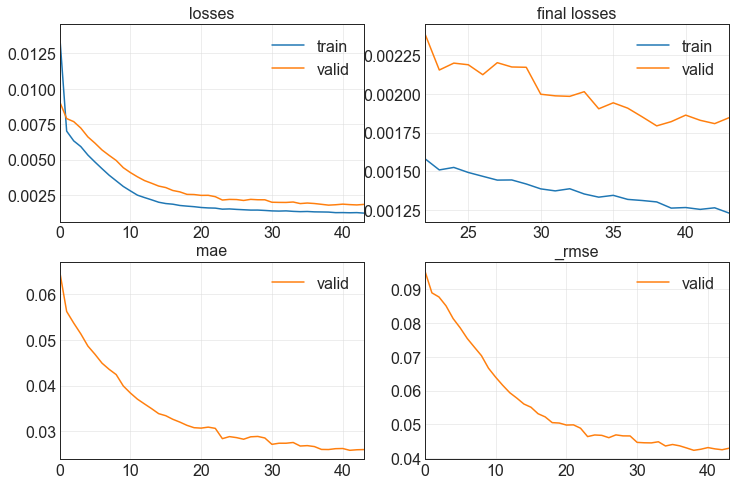

59.177449226379395                                                                                                     
[0.001230896799825132, 0.0018464077729731798, 0.025940431281924248, 0.042969848960638046]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 90%|█████████████████████████████████████▊    | 90/100 [2:49:27<14:27, 86.74s/trial, best loss: 0.0014441880630329251]

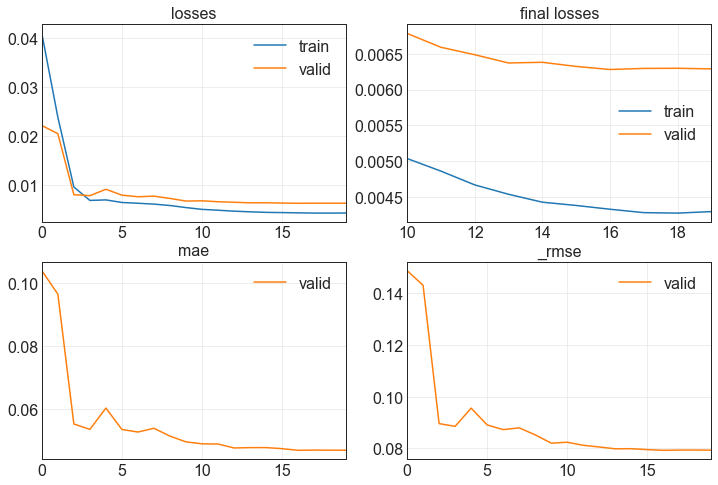

31.120015621185303                                                                                                     
[0.00429404666647315, 0.00629002321511507, 0.047086119651794434, 0.07930967211723328]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 91%|██████████████████████████████████████▏   | 91/100 [2:49:59<10:33, 70.40s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 4: early stopping                                                                           
 91%|██████████████████████████████████████▏   | 91/100 [2:50:13<10:33, 70.40s/trial, best loss: 0.0014441880630329251]

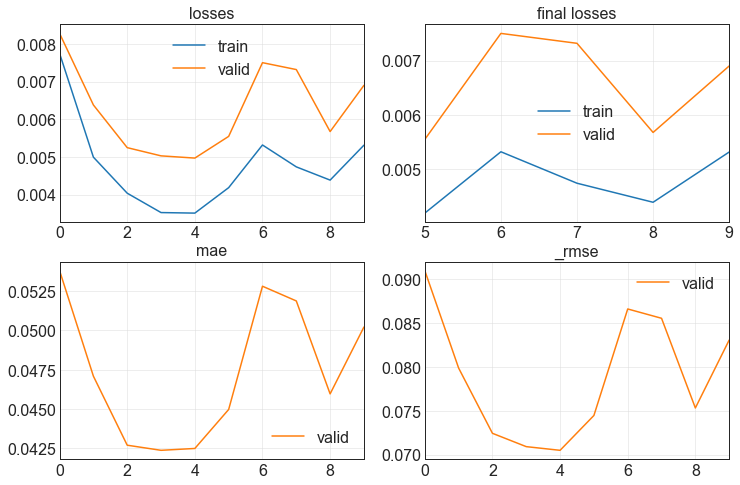

13.791722297668457                                                                                                     
[0.0053133596666157246, 0.006902212277054787, 0.05022166296839714, 0.08307954668998718]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 92%|██████████████████████████████████████▋   | 92/100 [2:50:14<07:10, 53.76s/trial, best loss: 0.0014441880630329251]

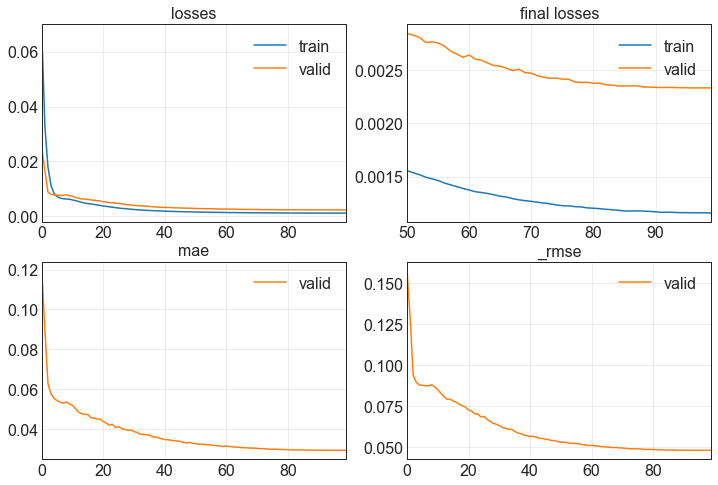

59.07330298423767                                                                                                      
[0.0011582470033317804, 0.0023313758429139853, 0.02941947802901268, 0.04828432574868202]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 93%|███████████████████████████████████████   | 93/100 [2:51:15<06:29, 55.69s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 44: early stopping                                                                          
 93%|███████████████████████████████████████   | 93/100 [2:52:33<06:29, 55.69s/trial, best loss: 0.0014441880630329251]

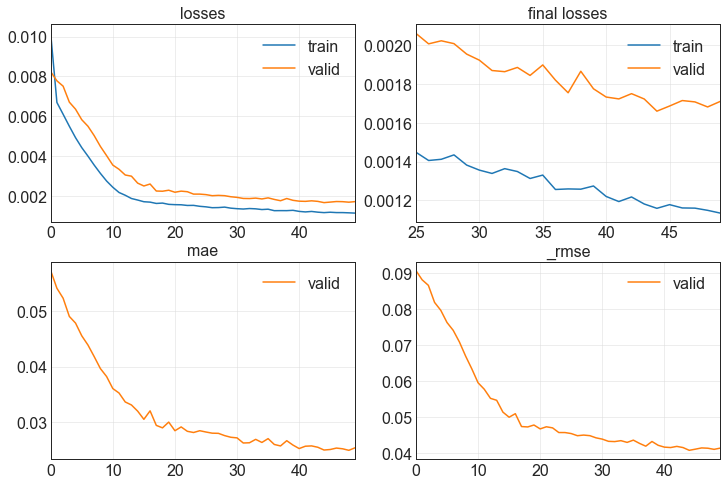

78.670401096344                                                                                                        
[0.0011344519443809986, 0.0017113825306296349, 0.025379836559295654, 0.041368864476680756]                             
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 94%|███████████████████████████████████████▍  | 94/100 [2:52:34<06:17, 62.95s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 34: early stopping                                                                          
 94%|███████████████████████████████████████▍  | 94/100 [2:54:21<06:17, 62.95s/trial, best loss: 0.0014441880630329251]

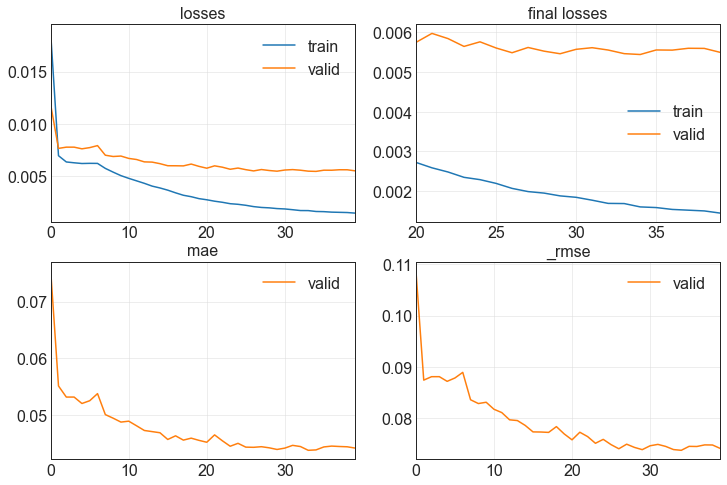

107.17531204223633                                                                                                     
[0.0014481012476608157, 0.005495758727192879, 0.044184405356645584, 0.07413338869810104]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 95%|███████████████████████████████████████▉  | 95/100 [2:54:23<06:22, 76.56s/trial, best loss: 0.0014441880630329251]

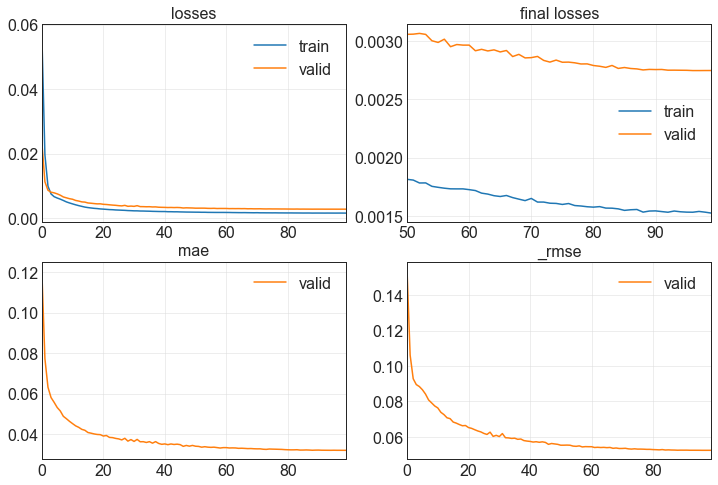

73.80060338973999                                                                                                      
[0.0015260211657732725, 0.0027460677083581686, 0.0319681353867054, 0.052402932196855545]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 96%|████████████████████████████████████████▎ | 96/100 [2:55:38<05:04, 76.08s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 2: early stopping                                                                           
 96%|████████████████████████████████████████▎ | 96/100 [2:56:01<05:04, 76.08s/trial, best loss: 0.0014441880630329251]

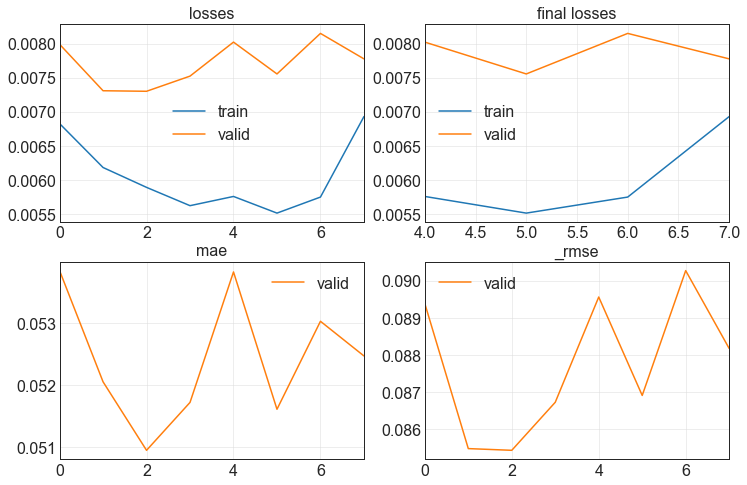

23.275402307510376                                                                                                     
[0.006928722374141216, 0.007774895057082176, 0.0524696409702301, 0.08817537128925323]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 97%|████████████████████████████████████████▋ | 97/100 [2:56:02<03:01, 60.59s/trial, best loss: 0.0014441880630329251]

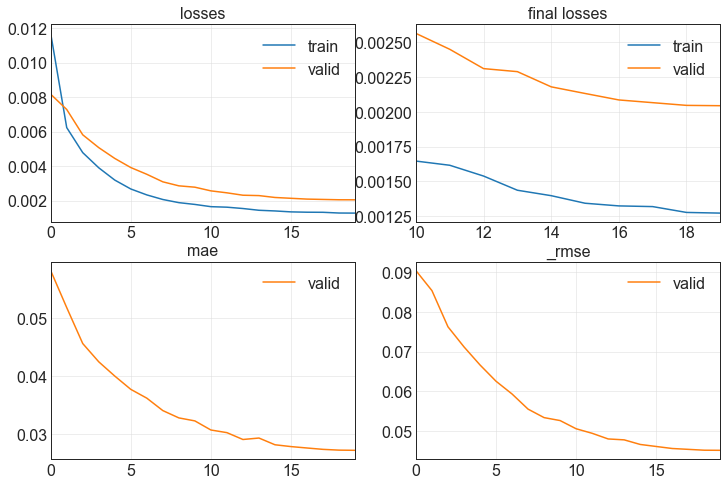

26.91546058654785                                                                                                      
[0.0012719010701403022, 0.0020434027537703514, 0.027254899963736534, 0.04520401358604431]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 98%|█████████████████████████████████████████▏| 98/100 [2:56:30<01:41, 50.83s/trial, best loss: 0.0014441880630329251]

No improvement since epoch 5: early stopping                                                                           
 98%|█████████████████████████████████████████▏| 98/100 [2:56:43<01:41, 50.83s/trial, best loss: 0.0014441880630329251]

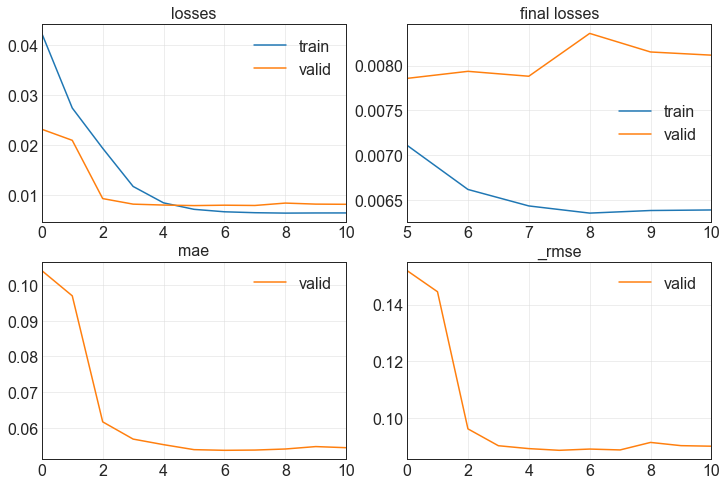

12.829376935958862                                                                                                     
[0.006389864254742861, 0.008115430362522602, 0.05443218722939491, 0.09008568525314331]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}
GRU                                                                                                                    
 99%|█████████████████████████████████████████▌| 99/100 [2:56:44<00:39, 39.79s/trial, best loss: 0.0014441880630329251]

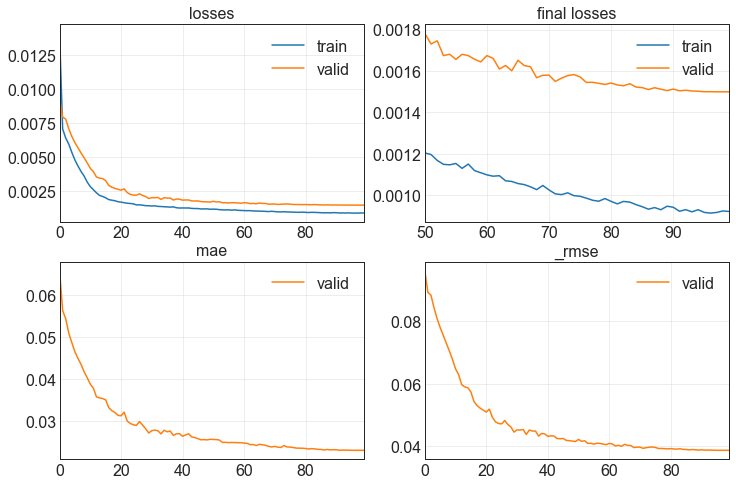

132.768301486969                                                                                                       
[0.0009225863614119589, 0.0014997674152255058, 0.02306203357875347, 0.03872682899236679]                               
100%|████████████████████████████████████████| 100/100 [2:58:57<00:00, 107.38s/trial, best loss: 0.0014441880630329251]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002DA7EB55438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(7990, 196, 10)

In [62]:
y.shape

(7990, 196)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = GRU
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

GRU


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): GRU(
    (rnn): GRU(196, 200, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=400, out_features=196, bias=True)
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

556,196 total parameters.
556,196 training parameters.


Training the model:

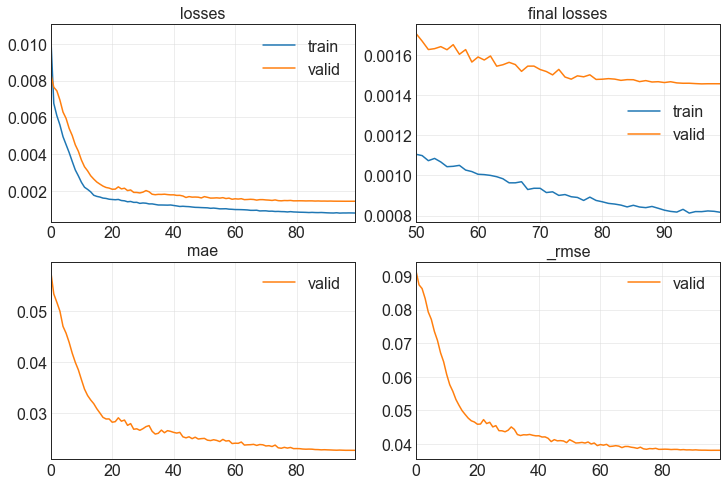

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

1999


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.6774, 0.1858, 0.7846,  ..., 0.5345, 0.0019, 0.0018],
         [0.7097, 0.2002, 0.7700,  ..., 0.5610, 0.0019, 0.0018],
         [0.7282, 0.1904, 0.7425,  ..., 0.5242, 0.0018, 0.0017],
         ...,
         [0.7749, 0.1815, 0.6488,  ..., 0.6971, 0.0019, 0.0018],
         [0.7925, 0.1907, 0.6489,  ..., 0.6789, 0.0018, 0.0017],
         [0.7794, 0.1661, 0.6469,  ..., 0.6580, 0.0019, 0.0018]]),
 tensor([[0.7516, 0.2175, 0.7770,  ..., 0.5197, 0.0000, 0.0000],
         [0.7553, 0.2080, 0.7623,  ..., 0.5126, 0.0000, 0.0000],
         [0.7457, 0.1962, 0.7510,  ..., 0.4877, 0.0000, 0.0000],
         ...,
         [0.7723, 0.1825, 0.6382,  ..., 0.6950, 0.0000, 0.0000],
         [0.7608, 0.1724, 0.6434,  ..., 0.6812, 0.0000, 0.0000],
         [0.7262, 0.1734, 0.6523,  ..., 0.6877, 0.0000, 0.0000]]),
 tensor([[0.6774, 0.1858, 0.7846,  ..., 0.5345, 0.0019, 0.0018],
         [0.7097, 0.2002, 0.7700,  ..., 0.5610, 0.0019, 0.0018],
         [0.7282, 0.1904, 0.7425,  ..., 0.5242, 0.0018, 0.

In [73]:
test_targets.shape

torch.Size([1999, 196])

In [74]:
test_preds.shape

torch.Size([1999, 196])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(1999, 1, 196)

In [78]:
y_pred.shape

(1999, 1, 196)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(1999, 1, 196)

In [83]:
y_pred.shape

(1999, 1, 196)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  151.7778058052063
Test time (in seconds):  0.36699962615966797


In [92]:
print('Training time (in seconds) per epoch: ', 151.7778058052063 / 100)

Training time (in seconds) per epoch:  1.517778058052063


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  27.317224629634957
MAE:  8.588869365180672


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

GRU_TM-minmax_RMSE-10-1-step-1.pdf
GRU_TM-minmax_MAE-10-1-step-1.pdf


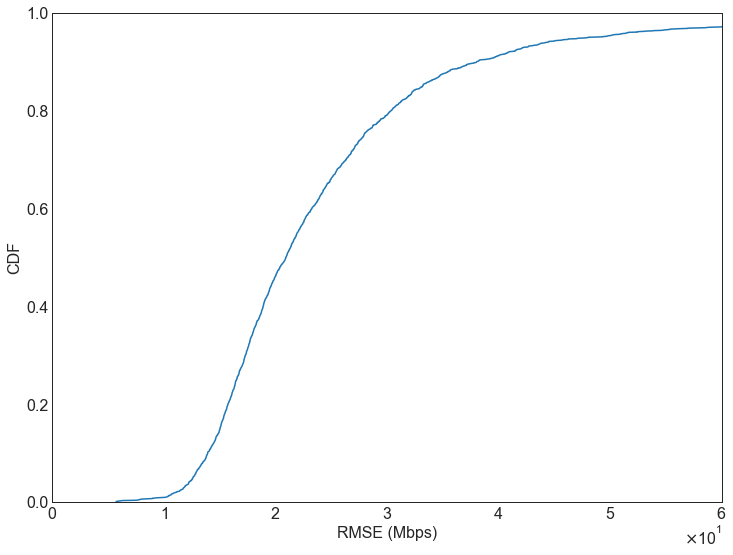

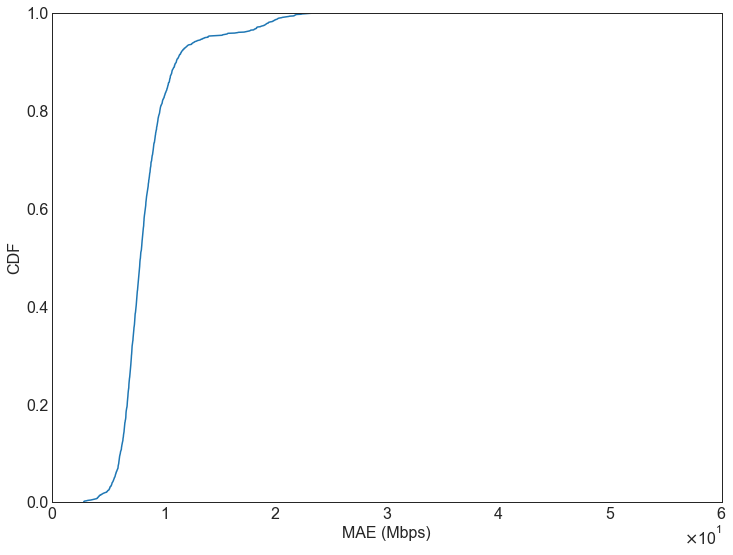

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)